In [433]:
__author__ = "Eduardo Gil González-Madroño"
__copyright__ = "Copyright 2020, Eduardo Gil González-Madroño"

__license__ = "GPL"
__version__ = "1.0.1"

__maintainer__ = "Eduardo Gil González-Madroño"
__email__ = "eggom84@gmail.com"

__status__ = "Dev"

# ............................Ames Iowa Housing Sale Price Prediction.............................
······································································································································································································


# Table of Contents

### 0. Notebook Initialization

* Import Libraries
* Settings for numbers of cross validation
* Definition of often used functions for the notebook
* Loading Data (Extraction)

### 1. Exploratory Data Analysis (EDA)

**1.0 Overview of features and initial look to target variable 'SalePrice'**
* head, shape, info, describe
* Distribution of the target variable SalePrice
* Numerical and Categorical features
* List of features with missing values and Filling missing values
* log transform

**1.1 Relation of all features to target SalePrice**
* Seaborn regression plots for numerical features
* List of numerical features and their correlation coefficient to target
* Seaborn boxplots for categorical features
* List of categorical features and their unique values

**1.2 Determine the columns that show strong correlation to target**
* Correlation Matrix 1 of all numerical features with strong correlation

### 2. Data Wrangling

* Dropping all columns with weak correlation to SalePrice
* Convert categorical columns to numerical
* Checking correlation to SalePrice for the new numerical columns
* Eliminate features with weak correlation to target
* Correlation Matrix 2 (including converted categorical columns)
* create datasets for ML algorithms
* One Hot Encoder
* StandardScaler

## 0. Notebook Initialization

#### 0.0  Lib Import and initialization

In [434]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

#### 0.1 Global Settings

In [3]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4

# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

# target feature
target = "SalePrice_Log"

#### 0.2 Global Functions

In [4]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [5]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [6]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [7]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(4)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [8]:
def skew_kurto_table(df,pct_feat_selection = 100):
    
    df_num_labels = df.select_dtypes(np.number).columns
        
    skew_list = []
    kurt_list = []
    max_list = []
    min_list = []
    range_list = []
    labels = []
    
    for col in df_num_labels:
        labels.append(col)
        skew_list.append(df_train[col].skew())
        kurt_list.append(df_train[col].kurt())
        max_list.append(df_train[col].max())
        min_list.append(df_train[col].min())
        range_list.append(df_train[col].max()-df_train[col].min())
    
    global_list = [labels,skew_list,kurt_list,max_list,min_list,range_list]

    df_return = pd.DataFrame(global_list).T
    df_return = df_return.rename(columns = {0 : 'feature', 1 : 'skewness', 2 : 'kurtosis', 3 : 'max_val', 4 : 'min_val', 5 : 'range'})

    df_return = df_return.sort_values(by="skewness", ascending=False)
    
    nb_of_feat = round(len(df_return)*(pct_feat_selection/100))
    
    return df_return.set_index("feature").head(nb_of_feat)

In [9]:
def skew_kurto_table_and_plot(df,pct_feat_selection = 100):
    
    # Selecting the numerical data:
    
    df_num_labels = df.select_dtypes(np.number).columns
    
    # Building the table and then dataframe:
    
    skew_list = []
    kurt_list = []
    max_list = []
    min_list = []
    range_list = []
    labels = []
    
    for col in df_num_labels:
        labels.append(col)
        skew_list.append(df_train[col].skew())
        kurt_list.append(df_train[col].kurt())
        max_list.append(df_train[col].max())
        min_list.append(df_train[col].min())
        range_list.append(df_train[col].max()-df_train[col].min())
    
    global_list = [labels,skew_list,kurt_list,max_list,min_list,range_list]

    df_return = pd.DataFrame(global_list).T
    df_return = df_return.rename(columns = {0 : 'feature', 1 : 'skewness', 2 : 'kurtosis', 3 : 'max_val', 4 : 'min_val', 5 : 'range'})

    df_return = df_return.sort_values(by="skewness", ascending=False)
    
    nb_of_feat = round(len(df_return)*(pct_feat_selection/100))
    
    print("Number of Features on table: ",nb_of_feat)
    
    # Plotting the KDE of the selected features:
    
    total_plots = len(df_return.set_index("feature").head(nb_of_feat))
    
    some_empty_plot = False
    overflow = False
    subplot_dist = [1,1]
    figsize = (4,5)
    
    if total_plots%2==1:
        total_plots += 1
        some_empty_plot = True

    if total_plots == 2:
        subplot_dist = [2,1]
        figsize = (4,7)
    elif total_plots == 4:
        subplot_dist = [2,2]
        figsize = (8,7)
    elif total_plots == 6:
        subplot_dist = [2,3]
        figsize = (12,7)
    elif total_plots == 8:
        subplot_dist = [2,4]
        figsize = (16,7)
    elif total_plots == 10:
        subplot_dist = [3,4]
        figsize = (16,10)
    elif total_plots == 12:
        subplot_dist = [3,4]
        figsize = (16,10)
    elif total_plots == 14:
        subplot_dist = [4,4]
        figsize = (16,12)
    elif total_plots == 16:
        subplot_dist = [4,4]
        figsize = (16,12)
    elif total_plots == 18:
        subplot_dist = [5,4]
        figsize = (16,16)
    elif total_plots == 20:
        subplot_dist = [5,4]
        figsize = (16,16)
    elif total_plots == 22:
        subplot_dist = [5,5]
        figsize = (16,16)
    elif total_plots == 24:
        subplot_dist = [5,5]
        figsize = (16,16)
    elif total_plots == 26:
        subplot_dist = [6,5]
        figsize = (16,18)
    elif total_plots == 28:
        subplot_dist = [6,5]
        figsize = (16,18)
    elif total_plots == 30:
        subplot_dist = [6,5]
        figsize = (16,18)
    else:
        overflow = True
        some_empty_plot = True

    fig, axs = plt.subplots(subplot_dist[0],subplot_dist[1], figsize=figsize)
    # axs is a 2D array with shape (6,5)
    # you can keep track of counters in your for-loop to place the resulting graphs
    # using ax=axs[i,j]
    # or an alternative is to use a generator that you can use to get the next axes
    # instance at every step of the loop
    
    row = 0
    
    for i in range(subplot_dist[0]):
        for j in range(subplot_dist[1]):
            if some_empty_plot == False:
                sns.distplot(df[df_return.set_index("feature").head(nb_of_feat).index[row]], ax=axs[i,j])
                row += 1
            else:
                if overflow == True:
                    print("\nToo many features to be plotted. Max is 30!. Table will be still available.\n")
                    break
                if row<nb_of_feat:
                    sns.distplot(df[df_return.set_index("feature").head(nb_of_feat).index[row]], ax=axs[i,j])
                    row += 1                    
                    
    return df_return.set_index("feature").head(nb_of_feat)

In [10]:
class plotGraph:
    
    ''' Class that plot graphs '''
    
    def __init__(self):
        self.setStyle()

    def setStyle(self, style = 'white'):
        sns.set(style = style)
    
    def plotBarText(self, df, fig, title, xLabel, xTicks, xLabelFS = 10,
                    xTicksFS = 12, plotC = 'b', barW = 0.65, barTxtFS = 10):
        
        ''' Process that draw a tuned bar plot with text above the bars '''
        
        _ = plt.bar(xTicks, df.iloc[:, 0], width = barW, color = plotC, alpha = 0.75)
        plt.title(title, fontsize = 14, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS)
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        for bar in _:
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+'%'

            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.85), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)
    
    def plotKDE(self, fig, title, kde, featureD, labels, 
                colors = ['b', 'g'], legLoc = 0, legFS = 12, titleFS = 15):
        
        ''' Process that draw KDE plots '''
        
        ax=sns.kdeplot(kde[0], color=colors[0], shade=True, label= labels[0])
        ax=sns.kdeplot(kde[1], color=colors[1], shade=True, label= labels[1])
        plt.title('{} {}'.format(featureD, title), fontsize = titleFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        if legLoc == 0 :
            plt.legend(frameon=False, loc = legLoc, fontsize = legFS)
        else :    
            plt.legend(frameon=False, bbox_to_anchor=(legLoc), fontsize = legFS)
        plt.tight_layout()
    
    def plotCorr(self, corr, title, figSize = [5,5], titleFS = 15, cmap = 'blues', annot = True, 
                square = True, fmt = '.2f', vMM = [-1,1], lineW = 0.25, cbarD = {}, rot = 90,
                annD = {}, ticksFS = 10, yLim = [0.0,0.0]):
        
        ''' Process that plot a correlation matrix '''

        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        f, ax = plt.subplots(figsize=(figSize))
        ax.set_title(title, fontdict={'fontsize': titleFS})
        sns.heatmap(corr, annot = annot, mask=mask, cmap=cmap, vmin=vMM[0], vmax=vMM[1],
                    center=0, fmt=fmt, annot_kws=annD, square=True, linewidths=lineW, 
                    cbar_kws=cbarD)
        plt.xticks(fontsize = ticksFS, rotation = rot, ha = 'right')
        plt.yticks(fontsize = ticksFS)
        plt.title(title, fontsize = titleFS)
        b,t = plt.ylim()
        plt.ylim(bottom=(b*yLim[0]), top = (t*yLim[1]))
        
    def plotBox(self, df, fig):
        ax = sns.boxplot(df, orient = 'h', palette = "muted")
        
    def plotBarH(self, X, y, fig, title, width, nType = '', symbol = '', 
                 fontS = 10, plotC = 'b', sep = [1,2]):
        
        ''' Process that draw a tuned horizontal bar plot with text on the bars '''
        
        self.setStyle('white')
        br = plt.barh(X, y, color = plotC, alpha = 0.7)
        plt.title(title, fontsize = 13, y = 1.05)
        plt.yticks(fontsize = 11)
        plt.xticks(fontsize = 0)
        plt.rcParams['axes.facecolor'] = 'white'
        l, r = plt.xlim()
        plt.xlim(left=(y.min()*0.6))
        plt.tick_params(top=False, bottom=False, left=False, right=False,
                        labelleft=True, labelbottom=False)
        
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        for bar in br:
            width = bar.get_width()
            sepN = sep[0] if width < 100 else sep[1]
            width  = str('{0:.0f}'.format(width)) + symbol
            plt.gca().text((bar.get_width()-sepN), bar.get_y() + bar.get_height()/3.25, str(width),
                           ha='center', color='black', fontsize=fontS)
            
    def plotConfMatrix(self, clfN, yTest, yPred, target_names, title='Confusion matrix', 
                       cmap=None, figSize = [8,6], normalize=True):
        
        ''' Process that draw the confussion matrix for given predictions '''
        
        cm = confusion_matrix(yTest, yPred)
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy
        fig = plt.figure(figsize=(figSize))
        if cmap is None: cmap = plt.get_cmap('Blues')
        if normalize: cm = (cm.astype('float')*100) / cm.sum(axis=1)[:, np.newaxis]

        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, cmap=cmap)
        if normalize : fig.colorbar(cax, ticks=np.arange(0,101,20))
        else : fig.colorbar(cax)
        ax.set_xticklabels([''] + target_names)
        ax.set_yticklabels([''] + target_names)
        plt.tick_params(axis='both', which='major', length=0)
        plt.ylabel('True', fontsize = 12)
        plt.xlabel('Predicted', fontsize = 12)
        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize: plt.text(j, i, "{:0.2f}%".format(cm[i, j]),
                                horizontalalignment="center",
                                color="white" if cm[i, j] > thresh else "black",
                                fontweight = 568, fontsize = 12)
            else: plt.text(j, i, "{:,}".format(cm[i, j]),
                           horizontalalignment="center",
                           color="white" if cm[i, j] > thresh else "black",
                           fontweight = 568, fontsize = 12)
        plt.tight_layout()
        ax.xaxis.set_label_coords(0.5, -0.075)
        
        # Print scores
        ax.text(2.55,-0.45,'== '+clfN+' ==',fontsize=12)
        ax.text(2.55,-0.20,'Accuracy: '+str(round(accuracy_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.0,'Precision: '+str(round(precision_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.2,'Recall: '+str(round(recall_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.4,'F1: '+str(round(f1_score(yTest, yPred),4)),fontsize=12)
        
    def plotFeatImp(self, X, Y, fig, title, xLabel, xLabelFS = 10, rot = 45,
                    xTicksFS = 11, plotC = 'b', barW = 0.9, barTxtFS = 11, simb = ''):
        
        ''' Process that draw bar plot for the feature importance '''
        
        _ = plt.bar(X, Y, width = barW, color = plotC)
        plt.title(title, fontsize = 15, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS, rotation = rot, ha = 'right')
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        i = 0
        for bar in _:
            if str(X.iloc[i])[:5] == 'basic':
                bar.set_color('g')
            elif str(X.iloc[i])[:5] == 'tfidf':
                bar.set_color('b')
            else:
                bar.set_color('r')  
            i = i +1
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+simb
            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.01), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)
        colors = {'Basic':'g', 'TF-IDF':'b', 'CountV' : 'r'}         
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        plt.legend(handles, labels)

In [11]:
def corr_target_table_descending(df,target,corr_thres=0.5):
    corr = df_train.corr()
    corr_abs = corr.abs()
    numerical_cols = len(df.select_dtypes(np.number).columns)
    ser_corr_abs = corr_abs.nlargest(numerical_cols, target)[target]
    #ser_corr = corr.nlargest(numerical_cols, target)[target]
    ser_corr_abs_df = pd.DataFrame(ser_corr_abs)
    
    cols_abv_corr_limit = list(ser_corr_abs_df[ser_corr_abs_df.values > corr_thres].index)
    cols_bel_corr_limit = list(ser_corr_abs_df[ser_corr_abs_df.values <= corr_thres].index)
    
    print("Total number of features above threshold: {} --> {:.0f}% of overall numerical features.\n".format(len(cols_abv_corr_limit), (len(cols_abv_corr_limit)/numerical_cols)*100))
    print("List of numerical features with r above correlation threshold of {}:\n".format(corr_thres))
    print(cols_abv_corr_limit)
    print("\n")
    print("*"*90)
    print("*"*90)
    print("\n")
    print("List of numerical features with r below correlation threshold of {}:\n".format(corr_thres))
    print(cols_bel_corr_limit)
    
    return ser_corr_abs_df.head(len(cols_abv_corr_limit))

In [12]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [13]:
def eta_table(df, target, corr_thres=0.5):
    
    # Find the features on dataframe (df) that are categorical:
    categorical_feats_labels = df.select_dtypes(["object","category"]).columns
    
    # Find the features on dataframe (df) that are categorical but no dichotomous:    
    categorical_n_values_labels = [catg for catg in list(categorical_feats_labels) if len(df_train[catg].unique())>=3]

    # Calculate eta correl and store it in lists:
    li_labels = []
    li_eta_values = []

    for catg in categorical_n_values_labels:
        li_labels.append(catg)
        eta = correlation_ratio(df_train[catg], df_train[target])
        li_eta_values.append(eta)   
#       print('{:18}'.format(catg), 
#              'Correlation: {:05.3f}'.format(eta), 
#            )

    # Build the return table (which is a dataframe)
    
    
    
    li_concat = [li_labels,li_eta_values]

    df_return = pd.DataFrame(li_concat).T
    df_return = df_return.rename(columns = {0 : 'feature', 1 : 'correl_ratio'})

    df_return = df_return.sort_values(by="correl_ratio", ascending=False)
    
    df_return = df_return.set_index("feature")
    
    print("Number of Features on table: ",len(df_return))
    
    
    
    cols_abv_corr_limit = list(df_return[df_return["correl_ratio"].values > corr_thres].index)
    cols_bel_corr_limit = list(df_return[df_return["correl_ratio"].values <= corr_thres].index)
    
    print("Total number of features above threshold: {} --> {:.0f}% of overall numerical features.\n".format(len(cols_abv_corr_limit), (len(cols_abv_corr_limit)/len(df_return))*100))
    print("List of numerical features with r above correlation threshold of {}:\n".format(corr_thres))
    print(cols_abv_corr_limit)
    print("\n")
    print("*"*90)
    print("*"*90)
    print("\n")
    print("List of numerical features with r below correlation threshold of {}:\n".format(corr_thres))
    print(cols_bel_corr_limit)
    
    return df_return.head(len(cols_abv_corr_limit))

In [113]:
def factorize_catg_ord_values(df, target, catg_strong_feats_labels = [], corr_thres = 0.0):
    
    import math
    import numpy as np
    import pandas as pd

    # If user passes list of categorical features then we use that list, if not, we create the list :)
    if catg_strong_feats_labels == []:
        catg_strong_feats_labels = df.select_dtypes("object" or "category").columns
    
    df_return = df.copy()
    
    for catg in catg_strong_feats_labels:
        means = df_return.groupby(catg)[target].mean()
        means_sorted = means.sort_values()
        denom = 1
        if len(means_sorted)>2:
            denom = 2
        if len(means_sorted)>6:
            denom = 3
        elif len(means_sorted)>12:
            denom = 6
        catg_ids_no = math.ceil(len(means_sorted)/denom)
        li_catg_ids = np.array(range(1,catg_ids_no+1))
        li_catg_ids = li_catg_ids.repeat(denom)
        li_catg_ids = list(li_catg_ids)
        catg_num = catg + "_numfct"
        df_return[catg_num]=0
        for i,j in zip(means_sorted.index, li_catg_ids):
            df_return[catg_num][df_return[catg]==i]=j
    
    first_numfct_pos = ((df_return.columns.str.find("_numfct")==-1).sum())
    
    new_col_num = list(df_return.dtypes.index[first_numfct_pos:])
    
    li_pearsonr = []
    
    nr_rows = math.floor(np.sqrt(len(new_col_num)))
    nr_cols = math.ceil(len(new_col_num)/nr_rows)

    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

    for r in range(0,nr_rows):
        for c in range(0,nr_cols):  
            i = r*nr_cols+c
            if i < len(new_col_num):
                sns.regplot(df_return[new_col_num[i]], df_return[target], ax = axs[r][c])
                stp = stats.pearsonr(df_return[new_col_num[i]], df_return[target])
                str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p-val = " + "{0:.2f}".format(stp[1])
                axs[r][c].set_title(str_title,fontsize=11)
                li_pearsonr.append(stp[0])
    
            
    plt.tight_layout()    
    plt.show() 

    # List of _numfct features sorted by correl descending
    print("*"*52,)
    print("*    Categorical Features and its 'correlation'    *")
    print("*"*52,"\n")
    
    list_of_tuples = list(zip(new_col_num,li_pearsonr))
    list_of_tuples_sorted = sorted(list_of_tuples, key=lambda tup: tup[1], reverse=True)
    li_numfct_labels = []
    li_numfct_corr_values = []
    for catg, corr in list_of_tuples_sorted:
        print( 
          'Category: {:21}'.format(catg) , 
          '   ' ,
          'Pearson R: {:04.3f}'.format(corr)  
         )
        li_numfct_labels.append(catg)
        li_numfct_corr_values.append(corr)
    
    # Create a dataframe of that list
    
    li_concat = [li_numfct_labels,li_numfct_corr_values]
    
    df_li_concat = pd.DataFrame(li_concat).T
    df_li_concat = df_li_concat.rename(columns = {0 : 'feature_numfct', 1 : 'correl_ratio'})
    df_li_concat = df_li_concat.set_index("feature_numfct")
    
    #print(df_li_concat.head(5))
    
    print("\nCorrel Ratio Threshold = ",corr_thres)
    print("\nNumber of Features: ",len(df_li_concat))
    
    cols_abv_corr_limit = list(df_li_concat[df_li_concat["correl_ratio"].values > corr_thres].index)
    cols_bel_corr_limit = list(df_li_concat[df_li_concat["correl_ratio"].values <= corr_thres].index)
    
    print("Number of Features above threshold: ",len(cols_abv_corr_limit))
    print(cols_abv_corr_limit)
    print("\nFeatures below threshold: ",len(cols_abv_corr_limit))
    print(cols_bel_corr_limit)
    
    return df_return

In [406]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    df = df.select_dtypes(np.number)
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [407]:
def rmse(target, guess):
    return np.sqrt(metrics.mean_squared_error(target, guess)
                  )

def adj_r2(target, guess, k):
    n = len(target)
    r2 = metrics.r2_score(target, guess)
    return 1 - (1-r2)*(n-1) / (n - k - 1)

def lr_model_performance(target, guess, k):
    n = len(target)
    return {
        "MAE": metrics.mean_absolute_error(target, guess),
        "RMSE": rmse(target, guess),
        "R^2_adj": adj_r2(target, guess, k)
           }

#### Load data (Extraction)

In [15]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

## 1. Exploratory Data Analysis (EDA)

### 1.0 Overview of features and initial look to target variable 'SalePrice'

Let's get a first overview of the train and test dataset:

    * How many rows and columns are there?
    * What are the names of the features (columns)?
    * Which features are numerical, which are categorical?
    * How many values are missing?

The <code>DF.shape</code> and <code>DF.info()</code> methods answer these questions.

<code>DF.head(n)</code> displays the first n rows of the DF.
<code>DF.sample(n)</code> displays the n random rows of the DF.

<code>DF.describe()</code> gives a summary of the statistics (only for numerical columns) of the DF.

In [16]:
print("Train DS shape -->",df_train.shape)
print("*"*50)
print("Test DS shape --->",df_test.shape)

Train DS shape --> (1460, 81)
**************************************************
Test DS shape ---> (1459, 80)


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [19]:
df_train.sample(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
461,462,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Feedr,Norm,1Fam,2Story,7,9,1936,2007,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,PConc,Gd,Gd,No,ALQ,350,BLQ,210,0,560,GasA,Ex,Y,SBrkr,575,560,0,1135,1,0,1,0,3,1,Gd,6,Typ,0,NaN,Detchd,1971.0,RFn,2,576,TA,TA,Y,256,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000
1037,1038,60,RL,NaN,9240,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,396.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1055,1055,GasA,Ex,Y,SBrkr,1055,1208,0,2263,0,0,2,1,3,1,Gd,7,Typ,1,TA,BuiltIn,2001.0,Fin,2,905,TA,TA,Y,0,45,0,0,189,0,NaN,NaN,NaN,0,9,2008,WD,Normal,287000


In [20]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Distribution of the target variable SalePrice

Skewness: 1.882876
Kurtosis: 6.536282


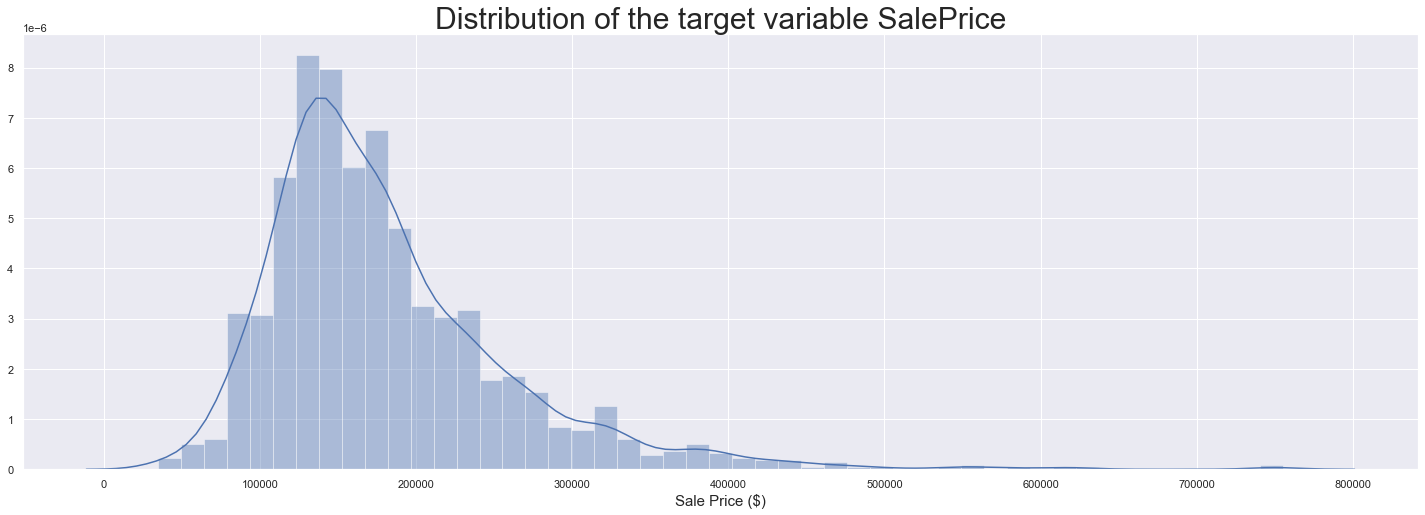

In [21]:
# Setting the size of the plot:
#
# Use '25' to ensure it will take the whole width of the notebook

plt.figure(figsize=(25,8))


# Setting the distplot:

sbx = sns.distplot(df_train['SalePrice']);

# Setting the plot title and axis labels:

sbx.set_title("Distribution of the target variable SalePrice", fontsize=30)
sbx.set_xlabel("Sale Price ($)", fontsize=15)

# Printing the values od skewness and kurtosis:

print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

As we see, the target variable _'SalePrice'_ is not normally distributed. This can reduce the performance of the ML regression models because some assume normal distribution.

_(see [sklearn info on preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html))_

Therefore let's make a log transformation and look at the shape of the distribution:

Skewness: 0.121335
Kurtosis: 0.809532


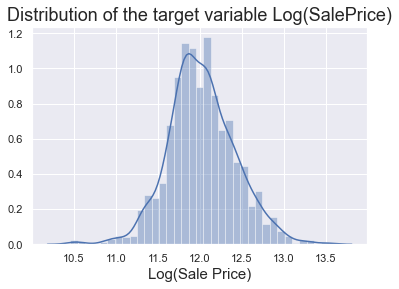

In [22]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])

sbx = sns.distplot(df_train['SalePrice_Log']);

sbx.set_title("Distribution of the target variable Log(SalePrice)", fontsize=18)
sbx.set_xlabel("Log(Sale Price)", fontsize=15)

# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())

# dropping old column
df_train.drop('SalePrice', axis= 1, inplace=True)

#### Numerical and Categorical Features

In [23]:
# Build the structures that contain the labels of the numerical and categorical features:

numerical_feats_labels = df_train.select_dtypes(np.number).columns
categorical_feats_labels = df_train.select_dtypes(["object","category"]).columns
print(len(categorical_feats_labels))
print("Nb of Numerical Features:   ",len(numerical_feats_labels))
print("Nb of Categorical Features: ",len(categorical_feats_labels))

43
Nb of Numerical Features:    38
Nb of Categorical Features:  43


In [24]:
df_train[numerical_feats_labels].dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice_Log    float64
dtype: object

In [25]:
df_train[numerical_feats_labels].sample(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log
219,220,120,43.0,3010,7,5,2005,2006,16.0,16,0,1232,1248,1248,0,0,1248,0,0,2,0,2,1,5,0,2005.0,2,438,108,0,0,0,0,0,0,3,2006,12.027185
1114,1115,20,90.0,5400,5,7,1954,2000,0.0,415,0,418,833,833,0,0,833,0,0,1,0,2,1,4,0,1955.0,1,326,0,0,0,0,0,0,0,8,2006,11.669929
729,730,30,52.0,6240,4,5,1925,1950,0.0,152,0,628,780,848,0,360,1208,0,0,1,0,2,1,5,0,1962.0,2,539,0,23,112,0,0,0,0,1,2009,11.542484


In [26]:
df_train[categorical_feats_labels].sample(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1184,RL,Grvl,NaN,Reg,Lvl,AllPub,Inside,Mod,Timber,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,CBlock,TA,TA,Gd,Rec,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,2Types,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1182,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Hip,CompShg,Wd Sdng,ImStucc,None,Gd,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,TA,Attchd,Fin,TA,TA,Y,Ex,MnPrv,NaN,WD,Abnorml
770,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,SFoyer,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Missing Values

In [27]:
missing_values_table(df_train)

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5205
MiscFeature,1406,96.3014
Alley,1369,93.7671
Fence,1179,80.7534
FireplaceQu,690,47.2603
LotFrontage,259,17.7397
GarageType,81,5.5479
GarageYrBlt,81,5.5479
GarageFinish,81,5.5479
GarageQual,81,5.5479


#### Filling Missing Values

For a few columns there is lots of NaN entries. However, reading the data description we find this is not missing data:
For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

Let's replace 'NaN' with 'None' in these columns.

In [28]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

After filling the NaN with None in those columns the result is:

In [29]:
missing_values_table(df_train)

Your selected dataframe has 81 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
LotFrontage,259,17.7397
GarageYrBlt,81,5.5479
MasVnrArea,8,0.5479


In [30]:
missing_values_table(df_test)

Your selected dataframe has 80 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
LotFrontage,227,15.5586
GarageYrBlt,78,5.3461
MasVnrArea,15,1.0281
BsmtFullBath,2,0.1371
BsmtHalfBath,2,0.1371
BsmtFinSF1,1,0.0685
BsmtFinSF2,1,0.0685
BsmtUnfSF,1,0.0685
TotalBsmtSF,1,0.0685
GarageCars,1,0.0685


Fill NaN with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea

In [31]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

Recheck of the missing values:

In [32]:
missing_values_table(df_train)

Your selected dataframe has 81 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [33]:
missing_values_table(df_test)

Your selected dataframe has 80 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Log Transform of some numerical values

Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in df_train and df_test. Checking for skewness and kurtosis:

In [34]:
s_k_df = skew_kurto_table(df_train)

Number of Features on table:  19


,skewness,kurtosis,max_val,min_val,range
feature,,,,,
MiscVal,24.4768,701.003,15500,0,15500
PoolArea,14.8284,223.268,738,0,738
LotArea,12.2077,203.243,215245,1300,213945
3SsnPorch,10.3043,123.662,508,0,508
LowQualFinSF,9.01134,83.2348,572,0,572
KitchenAbvGr,4.4884,21.5324,3,0,3
BsmtFinSF2,4.25526,20.1133,1474,0,1474
ScreenPorch,4.12221,18.4391,480,0,480
BsmtHalfBath,4.1034,16.3966,2,0,2


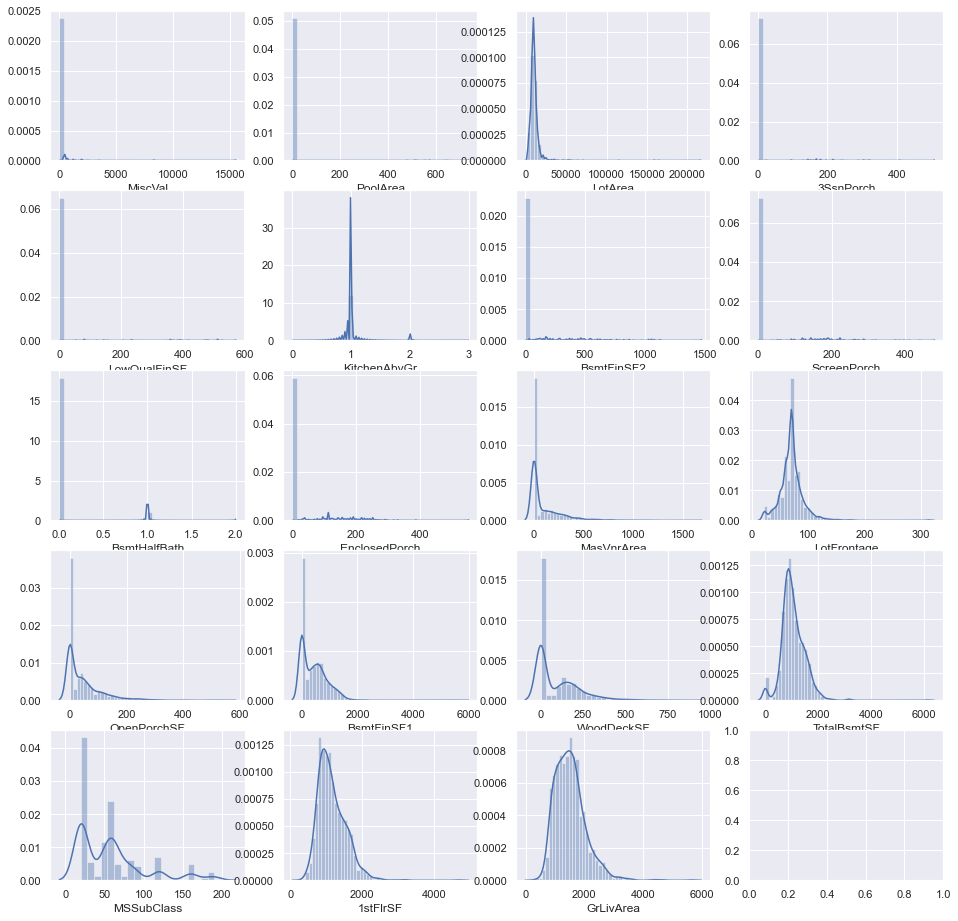

In [35]:
skew_kurto_table_and_plot(df_train,50)

Skewness: 1.366560
Kurtosis: 4.895121


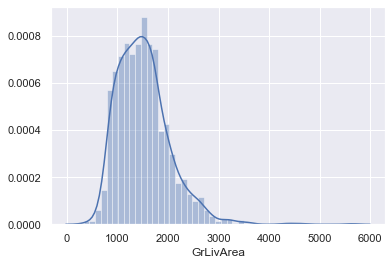

In [36]:
# GrLivArea

sns.distplot(df_train['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 12.207688
Kurtosis: 203.243271


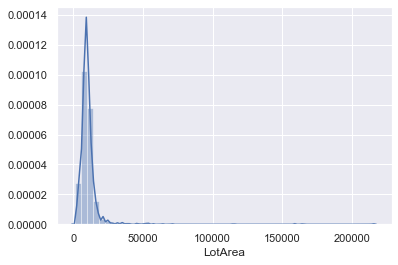

In [37]:
# LotArea

sns.distplot(df_train['LotArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

Skewness: 2.384950
Kurtosis: 21.848165


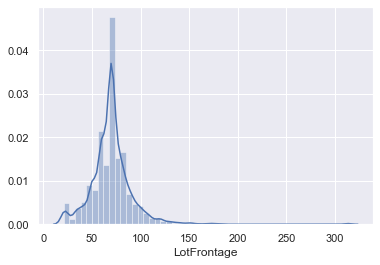

In [38]:
# LotFrontage

sns.distplot(df_train['LotFrontage']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotFrontage'].skew())
print("Kurtosis: %f" % df_train['LotFrontage'].kurt())

Skewness: 1.376757
Kurtosis: 5.745841


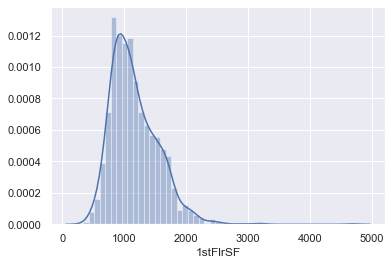

In [39]:
# 1stFlrSF

sns.distplot(df_train['1stFlrSF']);
#skewness and kurtosis
print("Skewness: %f" % df_train['1stFlrSF'].skew())
print("Kurtosis: %f" % df_train['1stFlrSF'].kurt())

In [40]:
# Let´s apply log to the features:

df_train['GrLivArea_Log'] = np.log(df_train['GrLivArea'])
df_train['LotArea_Log'] = np.log(df_train['LotArea'])
df_train['LotFrontage_Log'] = np.log(df_train['LotFrontage'])
df_train['1stFlrSF_Log'] = np.log(df_train['1stFlrSF'])

In [41]:
# Let´s apply log to the features in the test set:

df_test['GrLivArea_Log'] = np.log(df_test['GrLivArea'])
df_test['LotArea_Log'] = np.log(df_test['LotArea'])
df_test['LotFrontage_Log'] = np.log(df_test['LotFrontage'])
df_test['1stFlrSF_Log'] = np.log(df_test['1stFlrSF'])

Skewness: -0.006995
Kurtosis: 0.282603


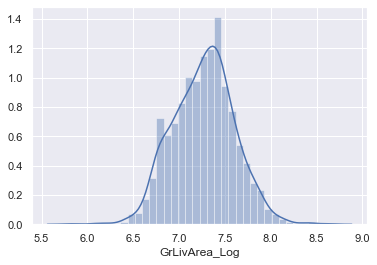

In [42]:
sns.distplot(df_train['GrLivArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % df_train['GrLivArea_Log'].kurt())

Skewness: -0.137994
Kurtosis: 4.713358


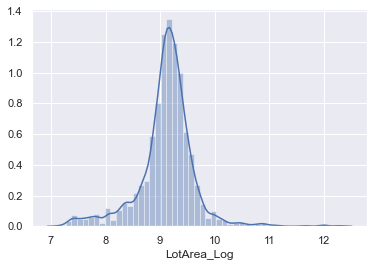

In [43]:
sns.distplot(df_train['LotArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea_Log'].skew())
print("Kurtosis: %f" % df_train['LotArea_Log'].kurt())

Skewness: -0.930795
Kurtosis: 3.558728


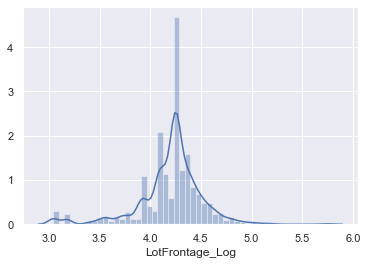

In [44]:
sns.distplot(df_train['LotFrontage_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotFrontage_Log'].skew())
print("Kurtosis: %f" % df_train['LotFrontage_Log'].kurt())

Skewness: 0.079157
Kurtosis: 0.150808


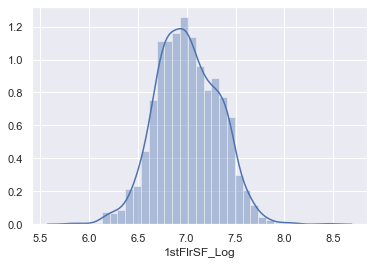

In [45]:
sns.distplot(df_train['1stFlrSF_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['1stFlrSF_Log'].skew())
print("Kurtosis: %f" % df_train['1stFlrSF_Log'].kurt())

### 1.1 Relation of features to target (SalePrice_log)

### Numerical Features

#### Scatterplots

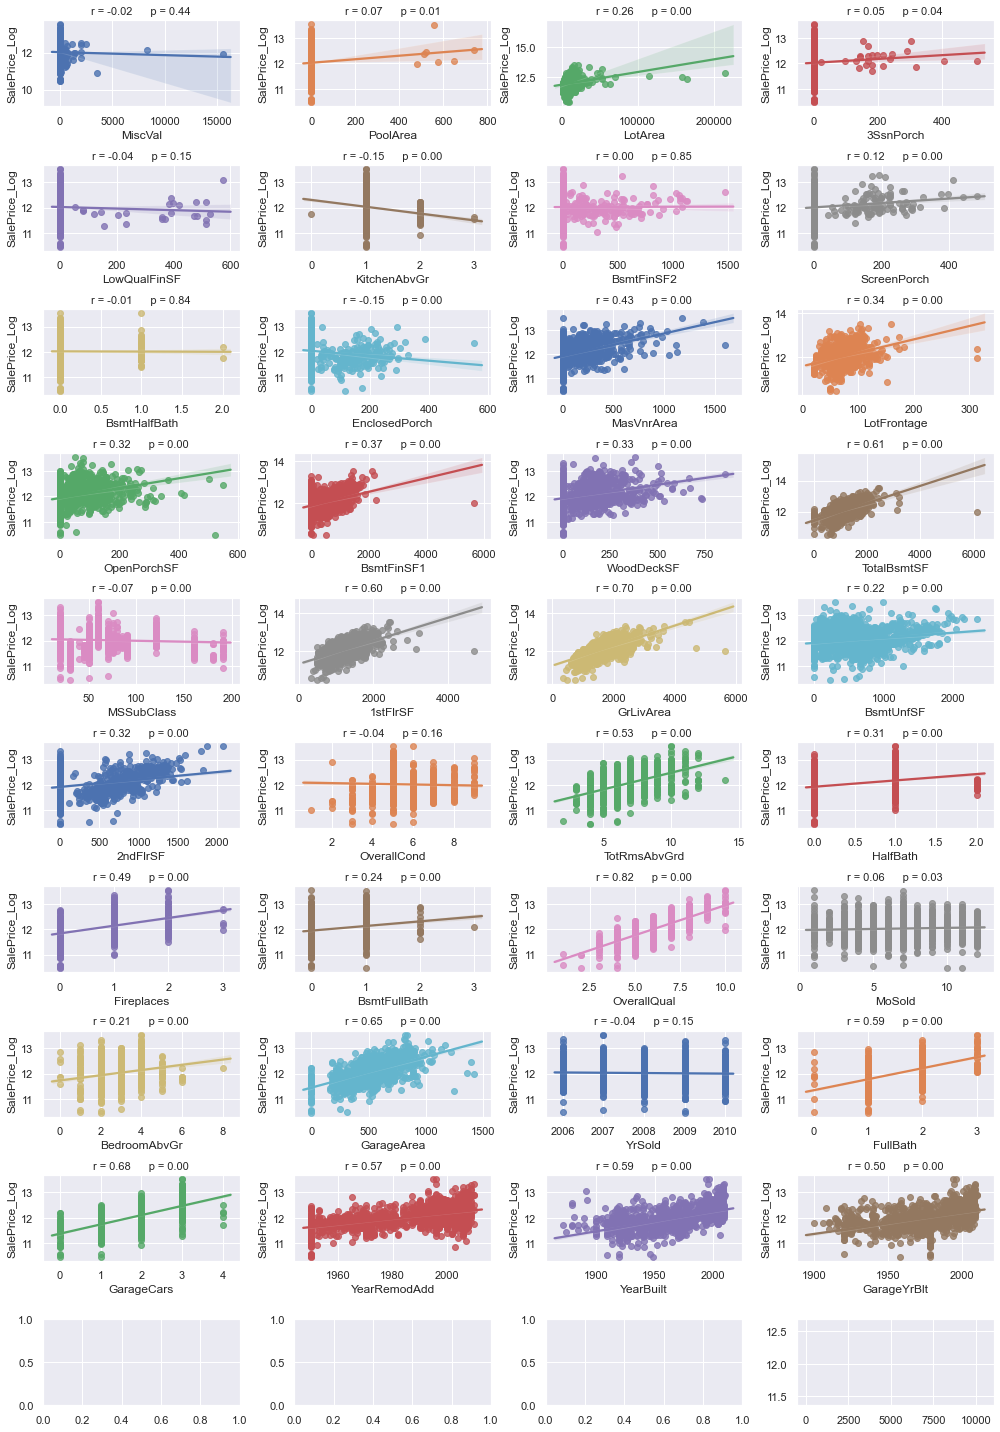

In [46]:
nr_rows = 10
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*2))

li_num_feats = list(s_k_df.index)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(s_k_df.index) if c not in li_not_plot]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train["SalePrice_Log"], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train["SalePrice_Log"])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

#### Correlation Heatmap

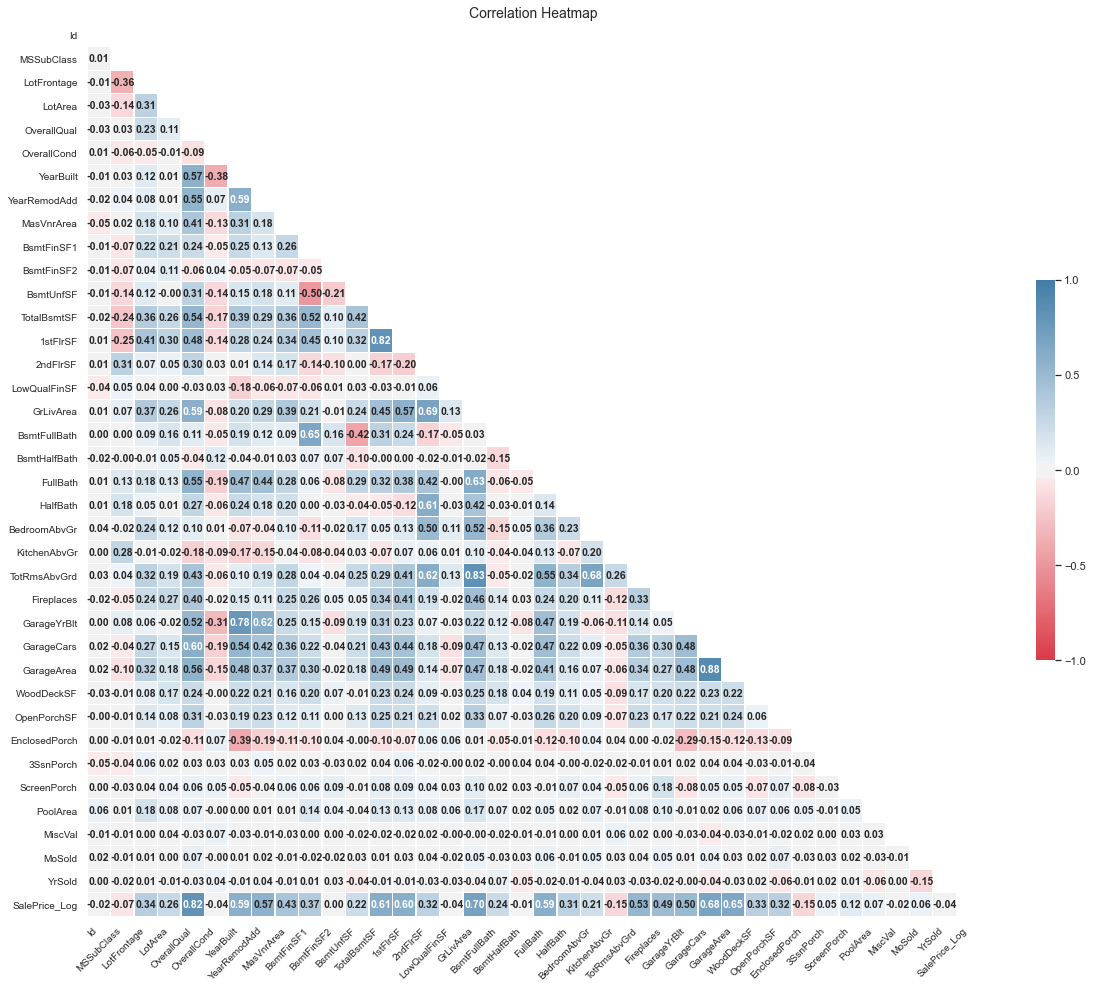

In [47]:
# Plot correlation matrix of the features and the target

statDF = df_train[numerical_feats_labels]

CorrCmap = sns.diverging_palette(10, 240, as_cmap=True)

pg = plotGraph()
pg.setStyle('whitegrid')
pg.plotCorr(statDF.corr(), 'Correlation Heatmap', figSize = [20,20], titleFS = 14,
            cmap = CorrCmap, lineW = 0.2, cbarD = {"shrink": .35, "ticks":[-1, -0.5, 0, 0.5,1]},
            annD = {'size': 10.5, 'weight' : 'bold'}, yLim = [1,0.0], rot=45)
plt.show()

In [48]:
corr_df = corr_target_table_descending(df_train,"SalePrice_Log", min_val_corr)
corr_df

Total number of features above threshold: 16 --> 38% of overall numerical features.

List of numerical features with r above correlation threshold of 0.4:

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF_Log', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'GarageYrBlt', 'Fireplaces', 'MasVnrArea']


******************************************************************************************
******************************************************************************************


List of numerical features with r below correlation threshold of 0.4:

['LotArea_Log', 'BsmtFinSF1', 'LotFrontage_Log', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'MSSubClass', 'PoolArea', 'MoSold', '3SsnPorch', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'Id', 'BsmtHalfBath', 'BsmtFinS

,SalePrice_Log
SalePrice_Log,1.000000
OverallQual,0.817184
GrLivArea_Log,0.730255
GrLivArea,0.700927
GarageCars,0.680625
GarageArea,0.650888
TotalBsmtSF,0.612134
1stFlrSF_Log,0.608947
1stFlrSF,0.596981
FullBath,0.594771


### Categorical Features

#### List of categorical features and their unique values

In [49]:
for catg in list(categorical_feats_labels) :
    print(df_train[catg].value_counts())
    print('#'*50)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1454
Grvl       6
Name: Street, dtype: int64
##################################################
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

#### Relation to SalePrice for all categorical features (Boxplots)

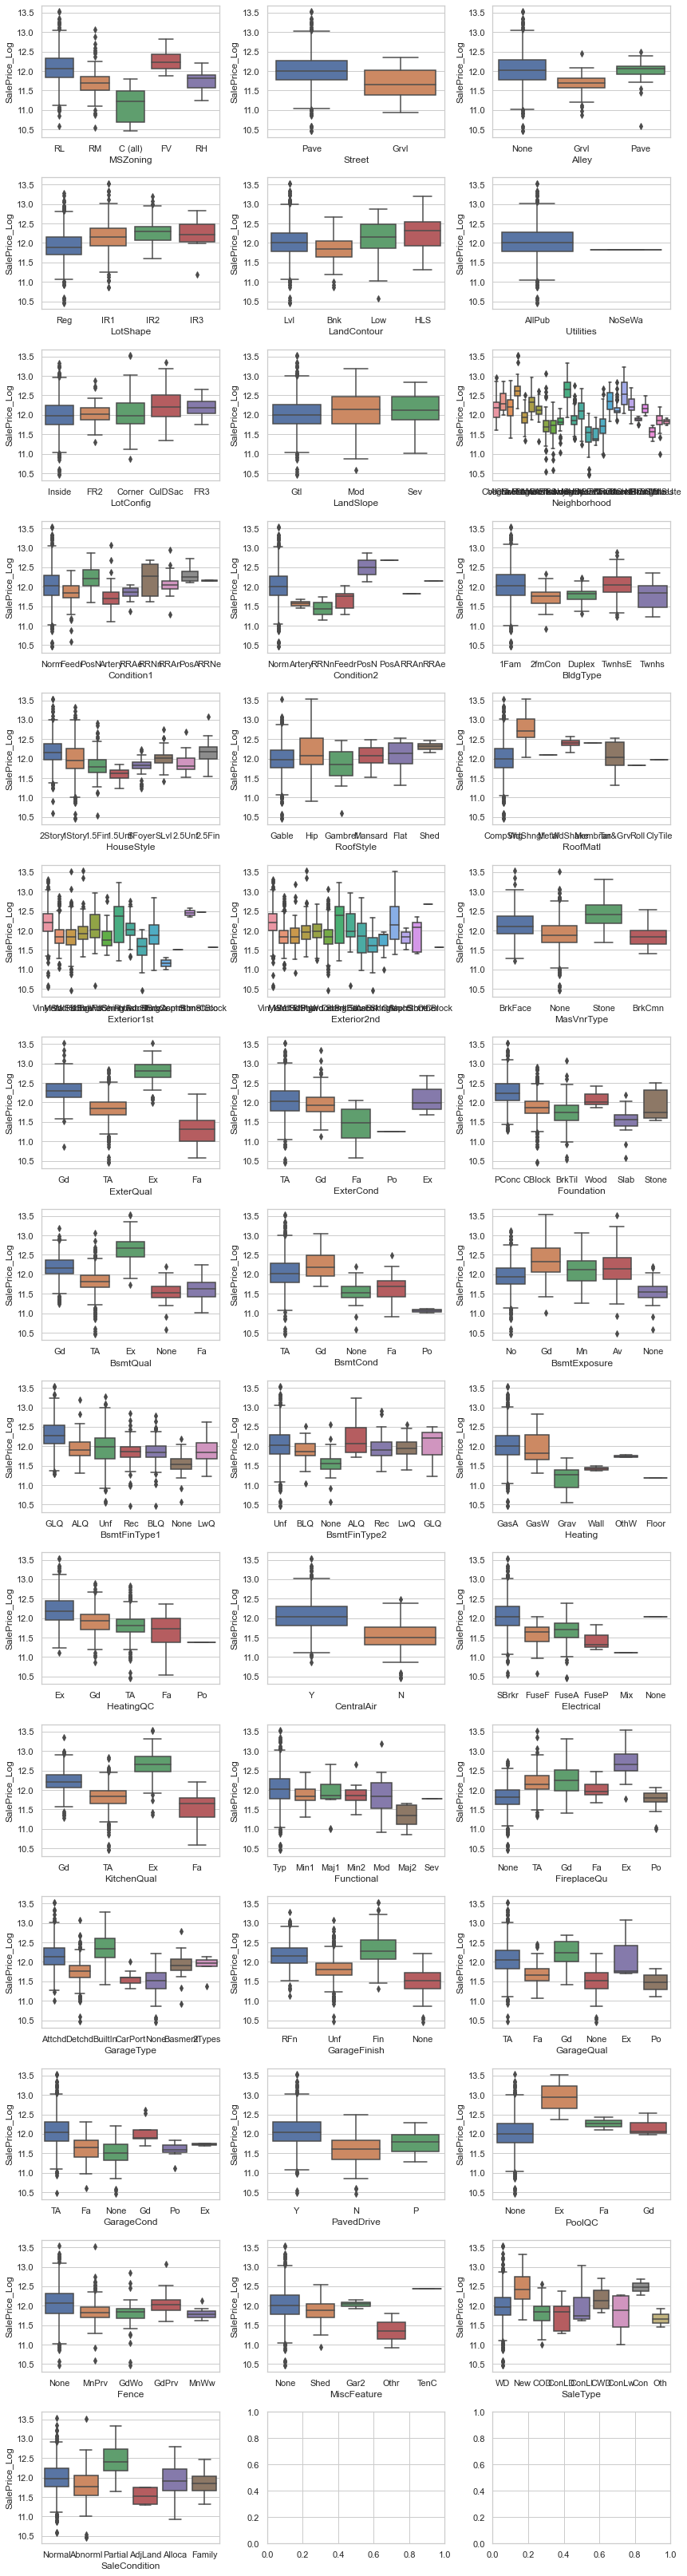

In [50]:
li_cat_feats = list(categorical_feats_labels)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()

#### Relation to SalePrice for all categorical features (correlation)

* For dichotomous (2-values) categorical features and a numerical value use point biserial correlation.
* For (n-values) categorical features and a numerical value use eta correlation.

In [51]:
# Figuring out which labels are 2-values and which ones are n-values:

categorical_2_values_labels = [catg for catg in list(categorical_feats_labels) if len(df_train[catg].unique())<3]
categorical_n_values_labels = [catg for catg in list(categorical_feats_labels) if len(df_train[catg].unique())>=3]

In [52]:
# OHE of the dichotomous values:

pd.get_dummies(df_train[categorical_2_values_labels]).head(3)

,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,CentralAir_N,CentralAir_Y
0,0,1,1,0,0,1
1,0,1,1,0,0,1
2,0,1,1,0,0,1


In [53]:
# Concat the df_train DF with this OHE DF:

df_train = pd.concat([df_train, pd.get_dummies(df_train[categorical_2_values_labels])], axis=1)

In [54]:
# Get the labels of the OHE dichotomous features:

OHE_2_values_labels = pd.get_dummies(df_train[categorical_2_values_labels]).columns

In [55]:
# Point biserial correlation of the OHE dichom features:

for catg in OHE_2_values_labels:
    pbr, p_val = stats.pointbiserialr(df_train[catg], df_train[target])
    print('{:18}'.format(catg), 
          'Correlation: {:06.3f}'.format(pbr) , 
          '   ' ,
          'p-value: {:04.4f}'.format(p_val)  
         )

Street_Grvl        Correlation: -0.057     p-value: 0.0284
Street_Pave        Correlation: 00.057     p-value: 0.0284
Utilities_AllPub   Correlation: 00.013     p-value: 0.6296
Utilities_NoSeWa   Correlation: -0.013     p-value: 0.6296
CentralAir_N       Correlation: -0.352     p-value: 0.0000
CentralAir_Y       Correlation: 00.352     p-value: 0.0000


In [56]:
# eta correlation for the categorical non dichotomous features

categorical_eta_thres_0dot3_df = eta_table(df_train,target,0.3)

Number of Features on table:  40
Total number of features above threshold: 22 --> 55% of overall numerical features.

List of numerical features with r above correlation threshold of 0.3:

['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'GarageType', 'FireplaceQu', 'Foundation', 'HeatingQC', 'BsmtFinType1', 'MasVnrType', 'Exterior1st', 'MSZoning', 'Exterior2nd', 'GarageCond', 'BsmtExposure', 'GarageQual', 'SaleCondition', 'SaleType', 'HouseStyle', 'Electrical', 'PavedDrive']


******************************************************************************************
******************************************************************************************


List of numerical features with r below correlation threshold of 0.3:

['LotShape', 'BsmtCond', 'ExterCond', 'BsmtFinType2', 'RoofStyle', 'Condition1', 'Fence', 'BldgType', 'Heating', 'Alley', 'LandContour', 'Functional', 'LotConfig', 'RoofMatl', 'Condition2', 'MiscFeature', 'PoolQC', 'LandSlope']


In [57]:
# Labels of the categorical non-dichom that are strong in eta correl:

categorical_eta_thres_0dot3_labels = categorical_eta_thres_0dot3_df.index

In [58]:
# Convert to list to be able to add "Central Air" which was the only one dichom significative feature:

categorical_eta_thres_0dot3_labels = list(categorical_eta_thres_0dot3_labels)
categorical_eta_thres_0dot3_labels.append('Central Air')

In [59]:
catg_weak_corr_labels = ['LotShape', 'BsmtCond', 'ExterCond', 'BsmtFinType2', 'RoofStyle', 'Condition1', 'Fence', 'BldgType',
                  'Heating', 'Alley', 'LandContour', 'Functional', 'LotConfig', 'RoofMatl', 'Condition2', 'MiscFeature',
                  'PoolQC', 'LandSlope']

In [60]:
num_weak_corr_labels = ['LotArea_Log', 'BsmtFinSF1', 'LotFrontage_Log', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF',
                        '2ndFlrSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch',
                        'KitchenAbvGr', 'ScreenPorch', 'MSSubClass', 'PoolArea', 'MoSold', '3SsnPorch', 'LowQualFinSF',
                        'YrSold', 'OverallCond', 'MiscVal', 'Id', 'BsmtHalfBath', 'BsmtFinSF2']

#### Correlation matrix 1

Features with largest correlation to SalePrice_Log all numerical features with correlation coefficient above threshold.

In [61]:
num_feats_pearson_r_abv_thres = ['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'GrLivArea', 'GarageCars', 'GarageArea',
                                 'TotalBsmtSF', '1stFlrSF_Log', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd',
                                 'TotRmsAbvGrd', 'GarageYrBlt', 'Fireplaces', 'MasVnrArea']

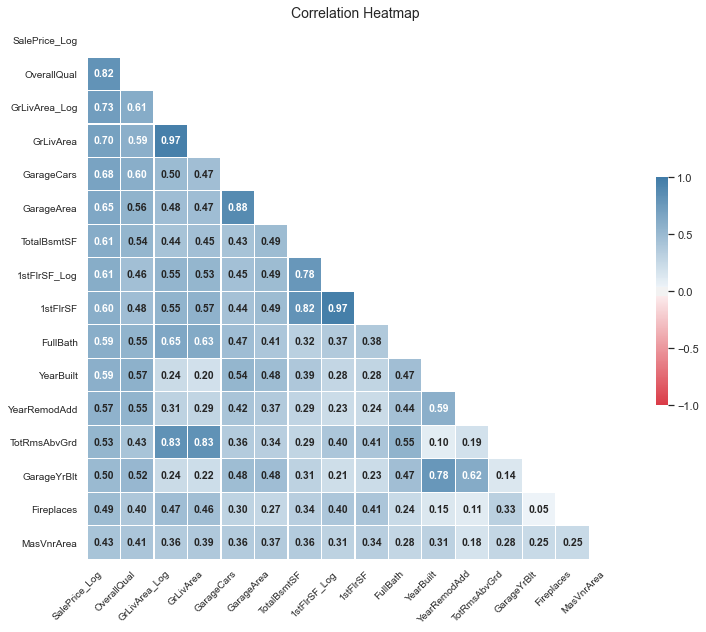

In [62]:
statDF = df_train[num_feats_pearson_r_abv_thres]

CorrCmap = sns.diverging_palette(10, 240, as_cmap=True)

pg = plotGraph()
pg.setStyle('whitegrid')
pg.plotCorr(statDF.corr(), 'Correlation Heatmap', figSize = [12,12], titleFS = 14,
            cmap = CorrCmap, lineW = 0.2, cbarD = {"shrink": .35, "ticks":[-1, -0.5, 0, 0.5,1]},
            annD = {'size': 10.5, 'weight' : 'bold'}, yLim = [1,0.0], rot=45)
plt.show()

Of those features with the largest correlation to SalePrice, some also are correlated strongly to each other.

To avoid failures of the ML regression models due to multicollinearity, these are dropped in part 2.

This is optional and controlled by the switch drop_similar (global settings)

## 2. Data Wrangling

#### Dropping all columns with weak correlation to SalePrice_Log for df_train and df_test

In [63]:
num_cols_to_drop = num_weak_corr_labels
catg_cols_to_drop = catg_weak_corr_labels
overall_cols_to_drop = ["Id"] + num_cols_to_drop + catg_cols_to_drop

In [64]:
df_train.drop(overall_cols_to_drop, inplace= True, axis = 1)

In [65]:
add_cols_to_drop = ["1stFlrSF","GrLivArea",'Street_Grvl', 'Street_Pave', 'Utilities_AllPub', 'Utilities_NoSeWa',
                    'CentralAir_N', 'CentralAir_Y']

In [66]:
df_train.drop(add_cols_to_drop, inplace= True, axis = 1)

In [67]:
id_df_test = df_test['Id']

Let's delete the cols that are in df_test but they are not in df_train.

In [68]:
df_train_cols = list(df_train.columns)
df_test_cols = list(df_test.columns)

In [69]:
cols_to_drop_df_test = list(set(df_test_cols) - set(df_train_cols))

In [70]:
df_test.drop(cols_to_drop_df_test, inplace= True, axis = 1)

In [71]:
add_cols_to_drop = ['LotArea_Log', 'LotFrontage_Log']

#### Convert categorical columns to numerical

For those categorical features where the EDA with boxplots seem to show a strong dependence (also for those with high values of eta or binary corr ratio) of the SalePrice on the category, we transform the columns to numerical.

To investigate the relation of the categories to SalePrice in more detail, we make violinplots for these features.

Also, we look at the mean of SalePrice as function of category.

In [72]:
catg_strong_feats_labels = df_train.select_dtypes("object").columns
catg_strong_feats_labels = list(catg_strong_feats_labels)
catg_strong_feats_labels.remove("Neighborhood")

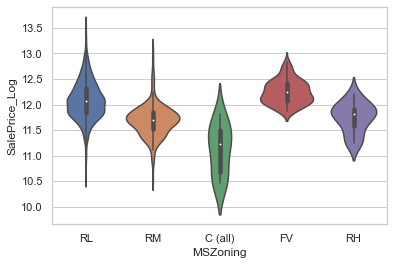

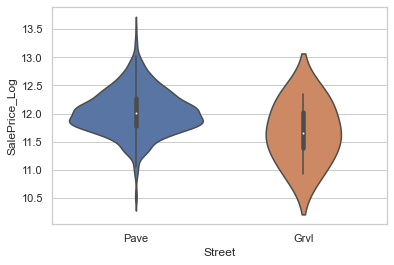

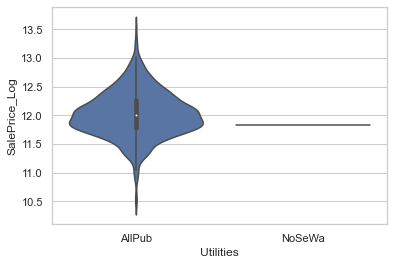

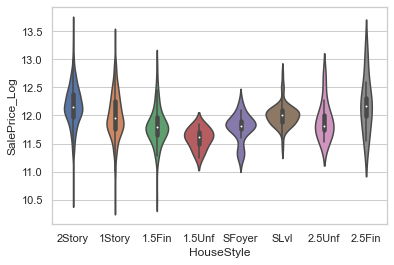

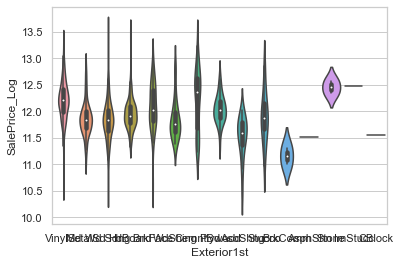

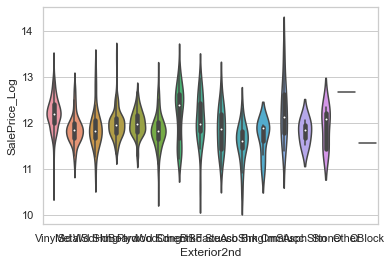

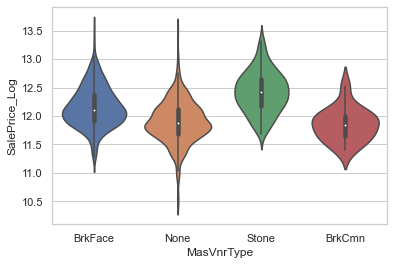

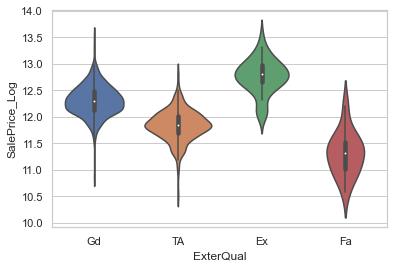

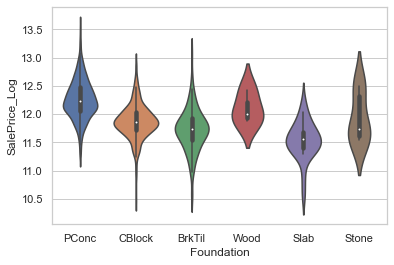

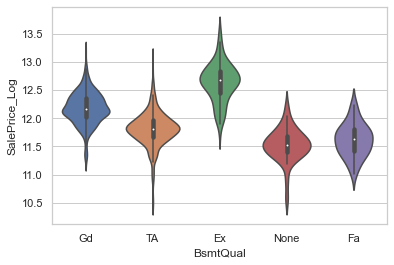

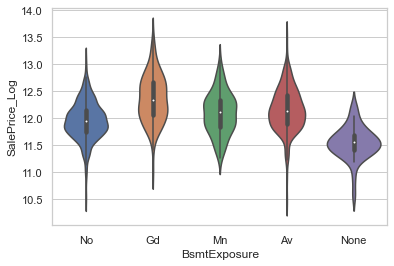

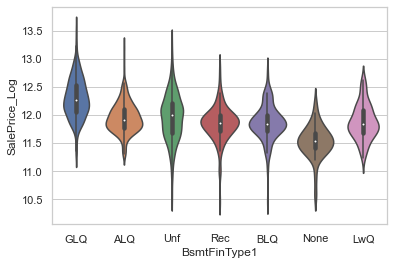

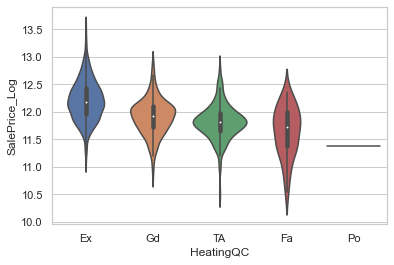

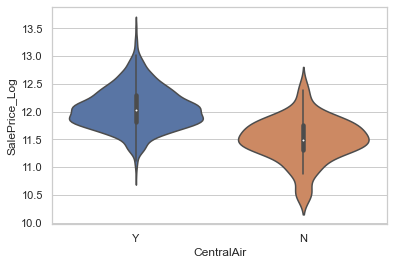

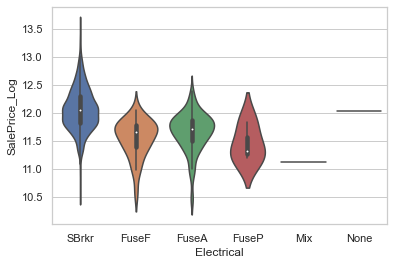

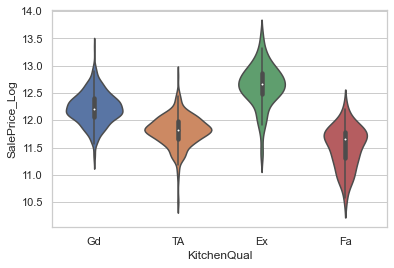

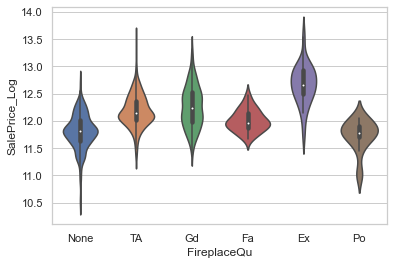

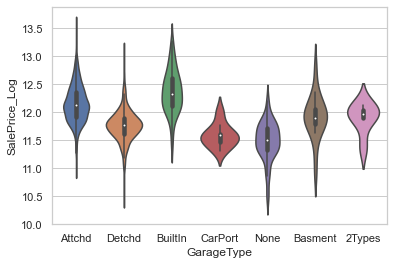

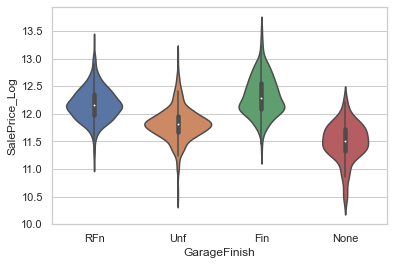

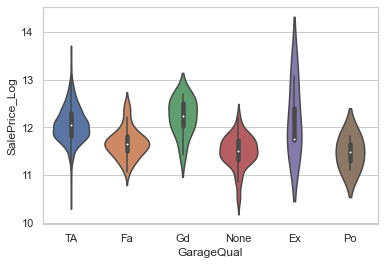

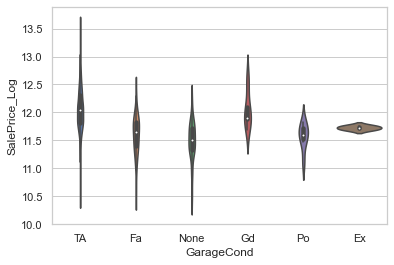

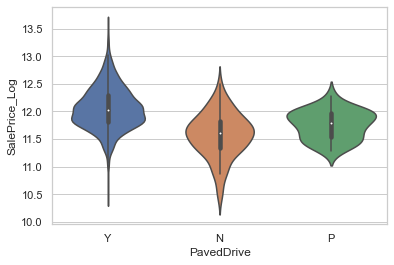

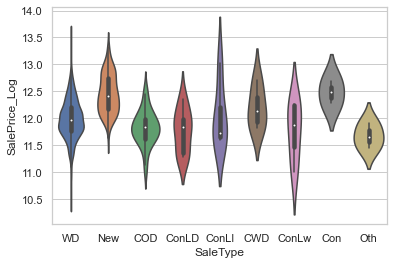

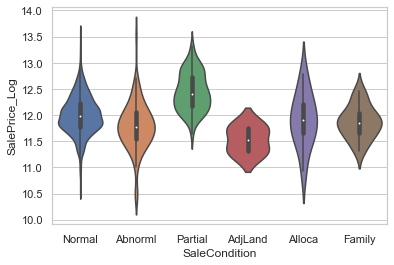

In [73]:
# Building the violin plots for the strong features:

for catg in catg_strong_feats_labels :
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()
    #sns.boxenplot(x=catg, y=target, data=df_train)
    #bp = df_train.boxplot(column=[target], by=catg)

#### Checking correlation to SalePrice for the new numerical columns

In [74]:
df_train_copy = df_train.copy()

In [75]:
df_train_copy.shape

(1460, 39)

C:\30.Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


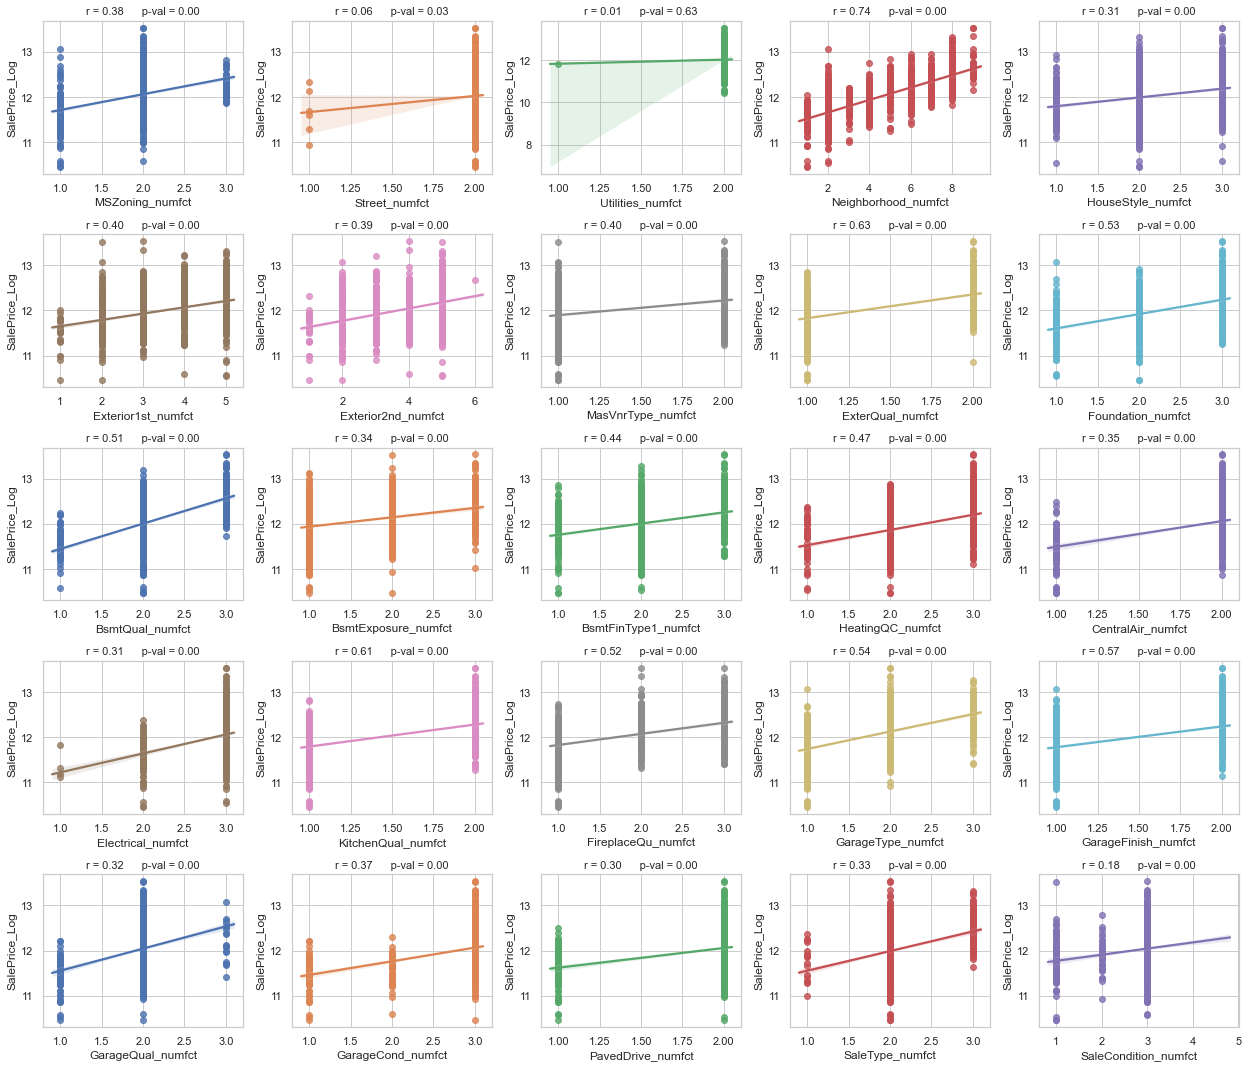

****************************************************
*    Categorical Features and its 'correlation'    *
**************************************************** 

Category: Neighborhood_numfct       Pearson R: 0.739
Category: ExterQual_numfct          Pearson R: 0.635
Category: KitchenQual_numfct        Pearson R: 0.609
Category: GarageFinish_numfct       Pearson R: 0.575
Category: GarageType_numfct         Pearson R: 0.543
Category: Foundation_numfct         Pearson R: 0.534
Category: FireplaceQu_numfct        Pearson R: 0.522
Category: BsmtQual_numfct           Pearson R: 0.507
Category: HeatingQC_numfct          Pearson R: 0.474
Category: BsmtFinType1_numfct       Pearson R: 0.438
Category: Exterior1st_numfct        Pearson R: 0.405
Category: MasVnrType_numfct         Pearson R: 0.399
Category: Exterior2nd_numfct        Pearson R: 0.395
Category: MSZoning_numfct           Pearson R: 0.378
Category: GarageCond_numfct         Pearson R: 0.374
Category: CentralAir_numfct         Pearson 

In [117]:
df_prueba = factorize_catg_ord_values(df_train_copy,target,corr_thres=0.29)

#### Time to drop columns that are not good for the model:

Building the lists of cols to drop:

In [154]:
catg_numfct_feat_to_drop = ['SaleCondition_numfct', 'Street_numfct', 'Utilities_numfct']

In [155]:
catg_feat_to_drop = ['Neighborhood', 'ExterQual', 'KitchenQual', 'GarageFinish', 'GarageType', 'Foundation', 'FireplaceQu', 'BsmtQual', 'HeatingQC', 'BsmtFinType1', 'Exterior1st', 'MasVnrType', 'Exterior2nd', 'MSZoning', 'GarageCond', 'CentralAir', 'BsmtExposure', 'SaleType', 'GarageQual', 'HouseStyle', 'Electrical', 'PavedDrive']

Dropping the actual cols:

In [156]:
df_train.drop(catg_numfct_feat_to_drop, inplace=True, axis=1)
df_train.drop(catg_feat_to_drop, inplace=True, axis=1)
df_test.drop(catg_feat_to_drop, inplace=True, axis=1)

In [158]:
# Check correlation on final models:

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)

SalePrice_Log          1.000000
OverallQual            0.817184
Neighborhood_numfct    0.738506
GrLivArea_Log          0.730255
GarageCars             0.680625
GarageArea             0.650888
ExterQual_numfct       0.634736
TotalBsmtSF            0.612134
1stFlrSF_Log           0.608947
KitchenQual_numfct     0.608832
FullBath               0.594771
YearBuilt              0.586570
GarageFinish_numfct    0.574553
YearRemodAdd           0.565608
GarageType_numfct      0.542866
TotRmsAbvGrd           0.534422
Foundation_numfct      0.534294
FireplaceQu_numfct     0.521869
BsmtQual_numfct        0.507407
GarageYrBlt            0.500449
Fireplaces             0.489449
HeatingQC_numfct       0.473587
BsmtFinType1_numfct    0.437783
MasVnrArea             0.429531
Exterior1st_numfct     0.404998
MasVnrType_numfct      0.398526
Exterior2nd_numfct     0.394972
MSZoning_numfct        0.378432
GarageCond_numfct      0.374393
CentralAir_numfct      0.351600
BsmtExposure_numfct    0.338836
SaleType

#### Correlation Matrix II

Version 1

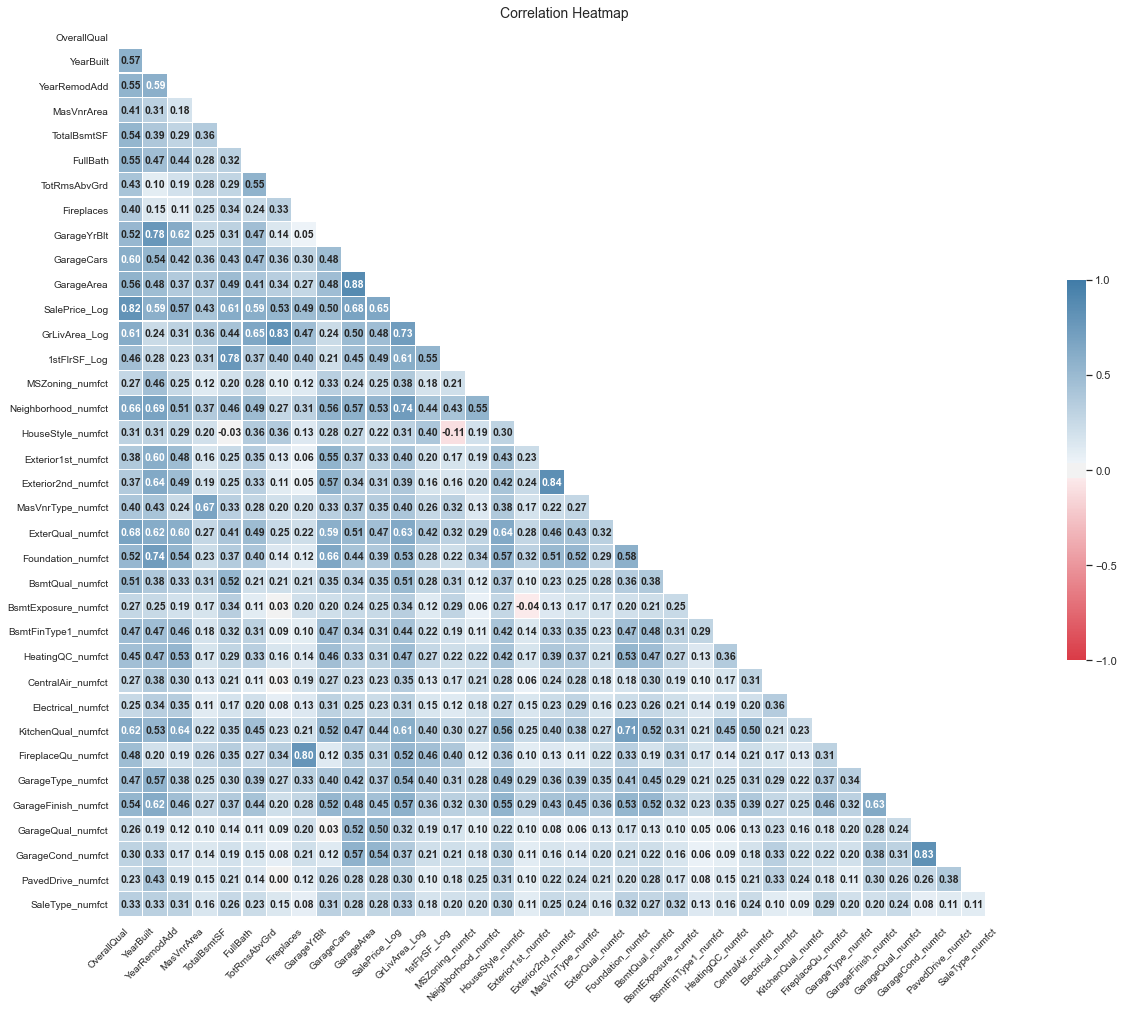

In [162]:
# statDF = df_train[num_feats_pearson_r_abv_thres]

CorrCmap = sns.diverging_palette(10, 240, as_cmap=True)

pg = plotGraph()
pg.setStyle('whitegrid')
pg.plotCorr(df_train.corr(), 'Correlation Heatmap', figSize = [20,20], titleFS = 14,
            cmap = CorrCmap, lineW = 0.2, cbarD = {"shrink": .35, "ticks":[-1, -0.5, 0, 0.5,1]},
            annD = {'size': 10.5, 'weight' : 'bold'}, yLim = [1,0.0], rot=45)
plt.show()

#### Correlation Matrix II

Version 2

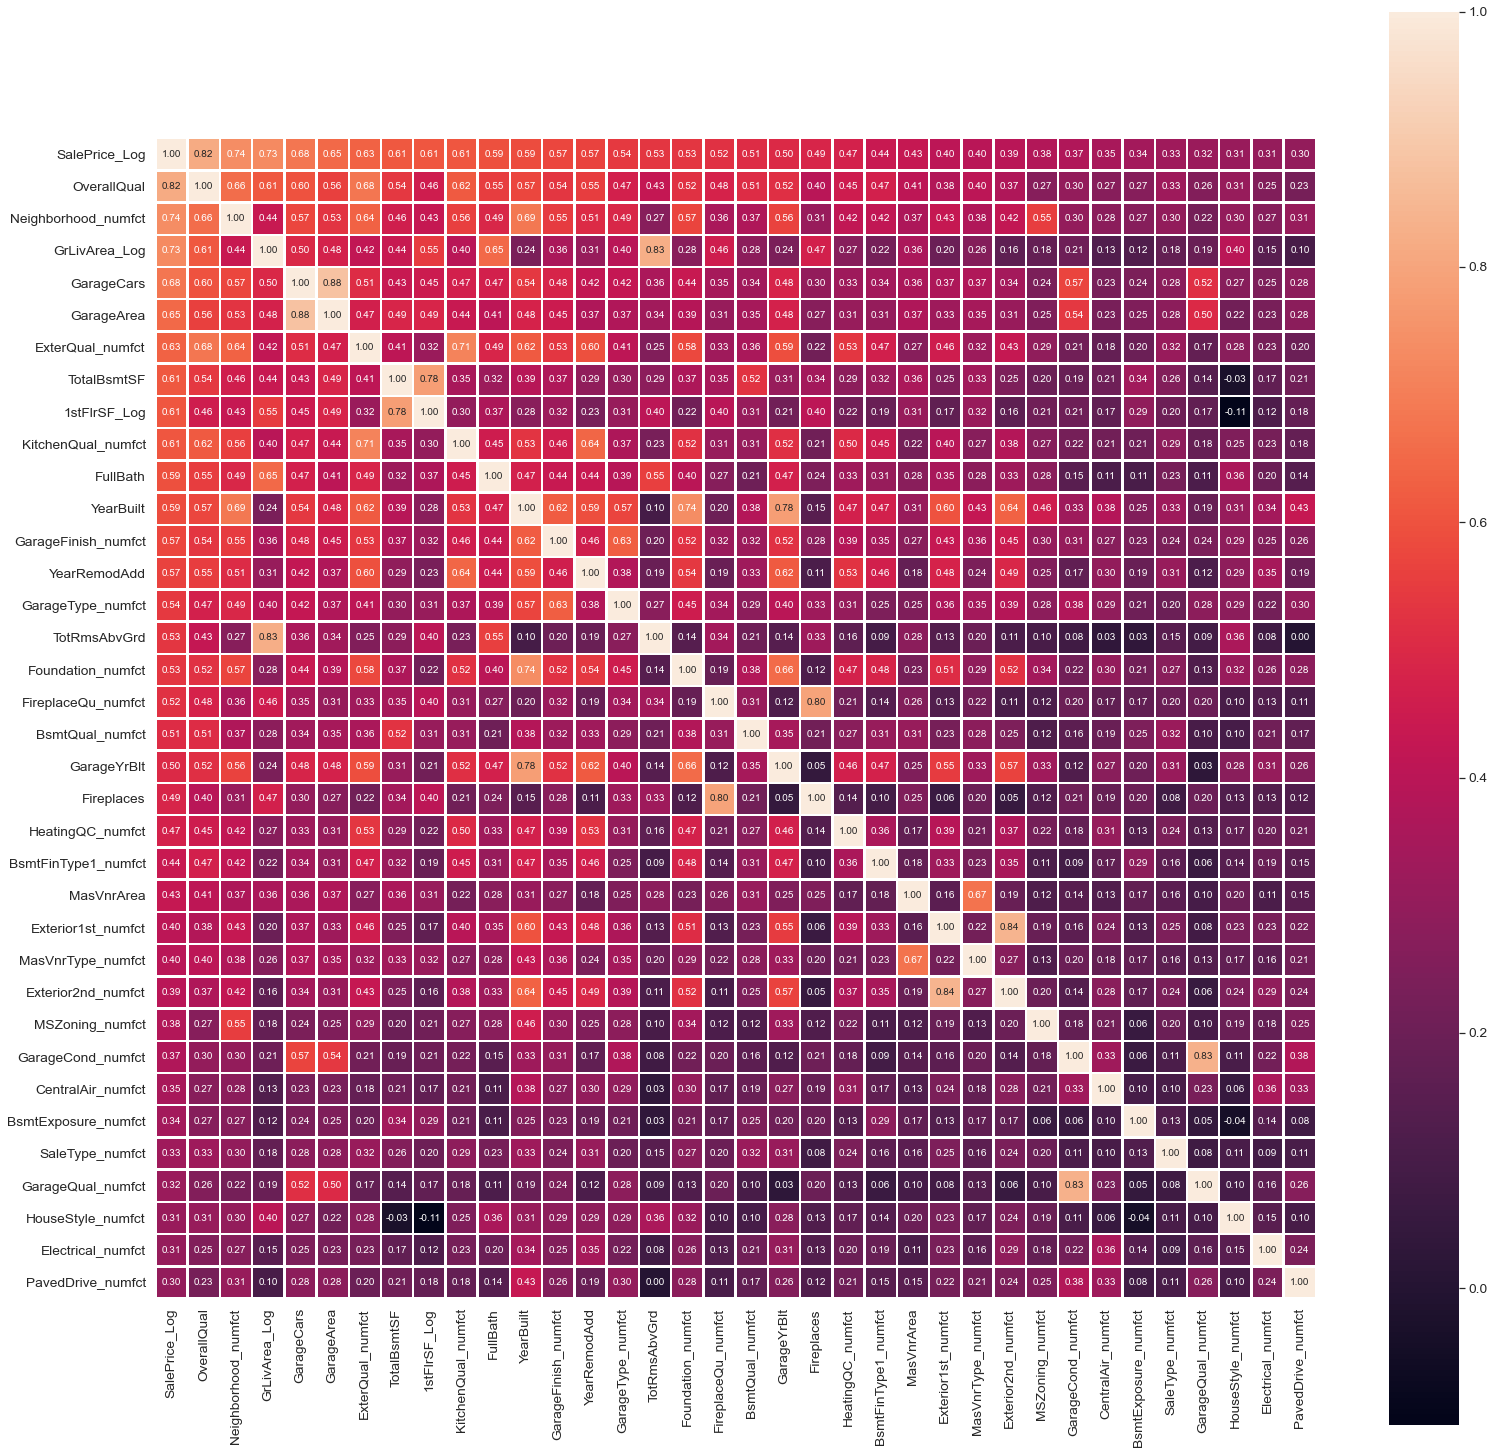

In [287]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

#### Check for multicolinearity

Look for the pairs that are more correlated.

From the features on those pairs, lets drop the ones with less correlation to the target value.

Additional Excel file done to help with this task.

We will delete all those features with high colinearity and "low" correlation to target variable.

In [288]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_train, 25))

Top Absolute Correlations
GarageCars           GarageArea             0.882475
Exterior1st_numfct   Exterior2nd_numfct     0.841376
GarageQual_numfct    GarageCond_numfct      0.834464
TotRmsAbvGrd         GrLivArea_Log          0.825498
OverallQual          SalePrice_Log          0.817184
Fireplaces           FireplaceQu_numfct     0.796603
YearBuilt            GarageYrBlt            0.780555
TotalBsmtSF          1stFlrSF_Log           0.779571
YearBuilt            Foundation_numfct      0.738820
SalePrice_Log        Neighborhood_numfct    0.738506
                     GrLivArea_Log          0.730255
ExterQual_numfct     KitchenQual_numfct     0.714294
YearBuilt            Neighborhood_numfct    0.687211
OverallQual          ExterQual_numfct       0.682810
GarageCars           SalePrice_Log          0.680625
MasVnrArea           MasVnrType_numfct      0.672007
OverallQual          Neighborhood_numfct    0.658709
GarageYrBlt          Foundation_numfct      0.656333
FullBath            

In [290]:
print(corr_target_table_descending(df_train,target,corr_thres=0.29))

Total number of features above threshold: 36 --> 100% of overall numerical features.

List of numerical features with r above correlation threshold of 0.29:

['SalePrice_Log', 'OverallQual', 'Neighborhood_numfct', 'GrLivArea_Log', 'GarageCars', 'GarageArea', 'ExterQual_numfct', 'TotalBsmtSF', '1stFlrSF_Log', 'KitchenQual_numfct', 'FullBath', 'YearBuilt', 'GarageFinish_numfct', 'YearRemodAdd', 'GarageType_numfct', 'TotRmsAbvGrd', 'Foundation_numfct', 'FireplaceQu_numfct', 'BsmtQual_numfct', 'GarageYrBlt', 'Fireplaces', 'HeatingQC_numfct', 'BsmtFinType1_numfct', 'MasVnrArea', 'Exterior1st_numfct', 'MasVnrType_numfct', 'Exterior2nd_numfct', 'MSZoning_numfct', 'GarageCond_numfct', 'CentralAir_numfct', 'BsmtExposure_numfct', 'SaleType_numfct', 'GarageQual_numfct', 'HouseStyle_numfct', 'Electrical_numfct', 'PavedDrive_numfct']


******************************************************************************************
**************************************************************************

After using the excel file, I conclude that the features to go are:

Fireplaces
MasVnrArea
Exterior1st_numfct
MasVnrType_numfct
Exterior2nd_numfct
GarageCond_numfct
GarageQual_numfct

In [302]:
# List with the features to remove based on this analysis I have done:

li_cols_to_drop = ["Fireplaces", "MasVnrArea", "Exterior1st_numfct", "MasVnrType_numfct", "Exterior2nd_numfct",
                "GarageCond_numfct", "GarageQual_numfct"]

In [304]:
# Build list of the features to be used for the ML models:
#
# Initially it´s all the columns in df_train:

li_df_train_cols = list(df_train.columns)

In [305]:
# This loop will look at the elements in the list 'li_cols_to_drop'. If that element is in the list li_df_train_cols
# then we remove that given element from the list:

for col in li_cols_to_drop:
    if col in li_df_train_cols: 
            li_df_train_cols.remove(col)

In [310]:
# Now let's remove the target label from the list:

li_df_train_cols.remove("SalePrice_Log")

In [311]:
# The overall number of features we´re gonna use for the ML models are, initially:

len(li_df_train_cols)

31

In [314]:
# And they are:

print(li_df_train_cols)

['Street', 'Utilities', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SaleCondition', 'GrLivArea_Log', '1stFlrSF_Log', 'MSZoning_numfct', 'Neighborhood_numfct', 'HouseStyle_numfct', 'ExterQual_numfct', 'Foundation_numfct', 'BsmtQual_numfct', 'BsmtExposure_numfct', 'BsmtFinType1_numfct', 'HeatingQC_numfct', 'CentralAir_numfct', 'Electrical_numfct', 'KitchenQual_numfct', 'FireplaceQu_numfct', 'GarageType_numfct', 'GarageFinish_numfct', 'PavedDrive_numfct', 'SaleType_numfct']


In [318]:
# Building the datasets for ML:

pred_df_train_ML = df_train[li_df_train_cols].copy()

y_target = df_train[target]


#### StandardScaler

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,GrLivArea_Log,1stFlrSF_Log,MSZoning_numfct,Neighborhood_numfct,HouseStyle_numfct,ExterQual_numfct,Foundation_numfct,BsmtQual_numfct,BsmtExposure_numfct,BsmtFinType1_numfct,HeatingQC_numfct,CentralAir_numfct,Electrical_numfct,KitchenQual_numfct,FireplaceQu_numfct,GarageType_numfct,GarageFinish_numfct,PavedDrive_numfct,SaleType_numfct
0,7,2003,2003,856,2,8,2003.000000,2,548,7.444249,6.752270,2,6,3,2,3,2,1,3,3,2,3,2,1,2,2,2,2
1,6,1976,1976,1262,2,6,1976.000000,2,460,7.140453,7.140453,2,7,2,1,2,2,3,2,3,2,3,1,2,2,2,2,2
2,7,2001,2002,920,2,6,2001.000000,2,608,7.487734,6.824374,2,6,3,2,3,2,2,3,3,2,3,2,2,2,2,2,2
3,7,1915,1970,756,1,7,1998.000000,3,642,7.448334,6.867974,2,6,3,1,1,2,1,2,2,2,3,2,3,1,1,2,2
4,8,2000,2000,1145,2,9,2000.000000,3,836,7.695303,7.043160,2,9,3,2,3,2,2,3,3,2,3,2,2,2,2,2,2
5,5,1993,1995,796,1,5,1993.000000,2,480,7.216709,6.679599,2,4,1,1,3,2,1,3,3,2,3,1,1,2,1,2,2
6,8,2004,2005,1686,2,7,2004.000000,2,636,7.434848,7.434848,2,7,2,2,3,3,2,3,3,2,3,2,3,2,2,2,2
7,7,1973,1973,1107,2,7,1973.000000,2,484,7.644919,7.009409,2,5,3,1,2,2,2,2,3,2,3,1,2,2,2,2,2
8,7,1931,1950,952,2,8,1931.000000,2,468,7.480992,6.929517,1,2,1,1,1,2,1,2,2,2,2,1,2,1,1,2,2
9,5,1939,1950,991,1,5,1939.000000,1,205,6.981935,6.981935,2,2,1,1,1,2,1,3,3,2,3,1,2,2,2,2,2


In [330]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(pred_df_train_ML.select_dtypes(np.number))

In [331]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.651479,1.050994,0.878668,-0.459303,0.789741,0.912210,1.021157,0.311725,0.351000,0.529260,-0.803570,0.257336,0.635439,1.278145,1.305260,0.996685,-0.092704,-0.632794,1.318117,0.934352,0.263813,0.301242,1.062205,-0.93210,0.473975,0.941438,0.299253,-0.24859
1,-0.071836,0.156734,-0.429577,0.466465,0.789741,-0.318683,-0.104483,0.311725,-0.060731,-0.381846,0.418585,0.257336,1.102579,-0.261535,-0.766131,-0.488172,-0.092704,2.431481,-0.096920,0.934352,0.263813,0.301242,-0.941438,0.24716,0.473975,0.941438,0.299253,-0.24859
2,0.651479,0.984752,0.830215,-0.313369,0.789741,-0.318683,0.937776,0.311725,0.631726,0.659675,-0.576560,0.257336,0.635439,1.278145,1.305260,0.996685,-0.092704,0.899344,1.318117,0.934352,0.263813,0.301242,1.062205,0.24716,0.473975,0.941438,0.299253,-0.24859
3,0.651479,-1.863632,-0.720298,-0.687324,-1.026041,0.296763,0.812705,1.650307,0.790804,0.541511,-0.439287,0.257336,0.635439,1.278145,-0.766131,-1.973029,-0.092704,-0.632794,-0.096920,-0.839580,0.263813,0.301242,1.062205,1.42642,-1.304954,-1.062205,0.299253,-0.24859
4,1.374795,0.951632,0.733308,0.199680,0.789741,1.527656,0.896086,1.650307,1.698485,1.282191,0.112267,0.257336,2.036859,1.278145,1.305260,0.996685,-0.092704,0.899344,1.318117,0.934352,0.263813,0.301242,1.062205,0.24716,0.473975,0.941438,0.299253,-0.24859


In [349]:
X = pred_df_train_ML.copy()
y = df_train[target]

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 31 columns):
Street                 1460 non-null object
Utilities              1460 non-null object
OverallQual            1460 non-null int64
YearBuilt              1460 non-null int64
YearRemodAdd           1460 non-null int64
TotalBsmtSF            1460 non-null int64
FullBath               1460 non-null int64
TotRmsAbvGrd           1460 non-null int64
GarageYrBlt            1460 non-null float64
GarageCars             1460 non-null int64
GarageArea             1460 non-null int64
SaleCondition          1460 non-null object
GrLivArea_Log          1460 non-null float64
1stFlrSF_Log           1460 non-null float64
MSZoning_numfct        1460 non-null int64
Neighborhood_numfct    1460 non-null int64
HouseStyle_numfct      1460 non-null int64
ExterQual_numfct       1460 non-null int64
Foundation_numfct      1460 non-null int64
BsmtQual_numfct        1460 non-null int64
BsmtExposure_numfct    1

#### IMPORTANT NOTE!!!

From the biserial correlation I forgot to drop the features 'Street' and 'Utilitities'.

I am doing it now.

In [352]:
X.drop(["Street","Utilities"], inplace=True, axis=1)
X.head(3)

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SaleCondition,GrLivArea_Log,1stFlrSF_Log,MSZoning_numfct,Neighborhood_numfct,HouseStyle_numfct,ExterQual_numfct,Foundation_numfct,BsmtQual_numfct,BsmtExposure_numfct,BsmtFinType1_numfct,HeatingQC_numfct,CentralAir_numfct,Electrical_numfct,KitchenQual_numfct,FireplaceQu_numfct,GarageType_numfct,GarageFinish_numfct,PavedDrive_numfct,SaleType_numfct
0,7,2003,2003,856,2,8,2003.0,2,548,Normal,7.444249,6.752270,2,6,3,2,3,2,1,3,3,2,3,2,1,2,2,2,2
1,6,1976,1976,1262,2,6,1976.0,2,460,Normal,7.140453,7.140453,2,7,2,1,2,2,3,2,3,2,3,1,2,2,2,2,2
2,7,2001,2002,920,2,6,2001.0,2,608,Normal,7.487734,6.824374,2,6,3,2,3,2,2,3,3,2,3,2,2,2,2,2,2


As well as drop "SaleCondition"

In [353]:
X.drop("SaleCondition", inplace=True, axis=1)
X.head(3)

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,GrLivArea_Log,1stFlrSF_Log,MSZoning_numfct,Neighborhood_numfct,HouseStyle_numfct,ExterQual_numfct,Foundation_numfct,BsmtQual_numfct,BsmtExposure_numfct,BsmtFinType1_numfct,HeatingQC_numfct,CentralAir_numfct,Electrical_numfct,KitchenQual_numfct,FireplaceQu_numfct,GarageType_numfct,GarageFinish_numfct,PavedDrive_numfct,SaleType_numfct
0,7,2003,2003,856,2,8,2003.0,2,548,7.444249,6.752270,2,6,3,2,3,2,1,3,3,2,3,2,1,2,2,2,2
1,6,1976,1976,1262,2,6,1976.0,2,460,7.140453,7.140453,2,7,2,1,2,2,3,2,3,2,3,1,2,2,2,2,2
2,7,2001,2002,920,2,6,2001.0,2,608,7.487734,6.824374,2,6,3,2,3,2,2,3,3,2,3,2,2,2,2,2,2


## 3. Scikit-learn basic regression models and comparison of results

Test simple sklearn models and compare by metrics

We test the following Regressors from scikit-learn:

LinearRegression<br>
Ridge<br>
Lasso<br>
Elastic Net<br>
Stochastic Gradient Descent<br>
DecisionTreeRegressor<br>
RandomForestRegressor<br>
SVR<br>

### Train Test Split

In [360]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model Tuning and selection with GridSearchCV

In [405]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

### Linear Regression

In [364]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X_train, y_train)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


0.15454591151133032
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [374]:
linregr_all = LinearRegression(normalize=True)
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X_train, y_train)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [375]:
sub_linreg = pd.DataFrame()
sub_linreg['SalePrice_y_test'] = y_test
sub_linreg['SalePrice_guess'] = pred_linreg_all
#sub_linreg.to_csv('linreg.csv',index=False)

In [404]:
for rs in range(1,1500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
    linregr_all = LinearRegression(normalize=True)
    #linregr_all.fit(X_train_all, y_train_all)
    linregr_all.fit(X_train, y_train)
    pred_linreg_all = linregr_all.predict(X_test)
    pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()
    sub_linreg = pd.DataFrame()
    sub_linreg['SalePrice_y_test'] = y_test
    sub_linreg['SalePrice_guess'] = pred_linreg_all
    perf = lr_model_performance(sub_linreg['SalePrice_y_test'], sub_linreg['SalePrice_guess'], 28)
    if perf['R^2_adj']>0.895:
        print("For random_state={}, the R^2_adj = {} and RMSE = {}".format(rs,perf['R^2_adj'],perf['RMSE']))

For random_state=949, the R^2_adj = 0.8959584304009236 and RMSE = 0.11977972428599455
For random_state=1391, the R^2_adj = 0.8957426243628088 and RMSE = 0.13123919805569367
For random_state=1418, the R^2_adj = 0.8961161716497626 and RMSE = 0.12774939783484227


### Ridge

In [409]:
from sklearn.linear_model import Ridge

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge.fit(X_train, y_train)

sc_ridge = get_best_score(grid_ridge)
sc_ridge

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.15258779431667305
{'alpha': 0.1, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.8s finished


0.15258779431667305

In [421]:
lr_model_performance(grid_ridge.predict(X_test), y_test, 28)

{'MAE': 0.10071451550700472,
 'RMSE': 0.14090701574078532,
 'R^2_adj': 0.8437417126307551}

In [422]:
for rs in range(1,1500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
    ridge = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=1e-06)
    #linregr_all.fit(X_train_all, y_train_all)
    ridge.fit(X_train, y_train)
    pred_linreg_all = ridge.predict(X_test)
    pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()
    sub_linreg = pd.DataFrame()
    sub_linreg['SalePrice_y_test'] = y_test
    sub_linreg['SalePrice_guess'] = pred_linreg_all
    perf = lr_model_performance(sub_linreg['SalePrice_y_test'], sub_linreg['SalePrice_guess'], 28)
    if perf['R^2_adj']>0.895:
        print("For random_state={}, the R^2_adj = {} and RMSE = {}".format(rs,perf['R^2_adj'],perf['RMSE']))

For random_state=949, the R^2_adj = 0.8951388969499926 and RMSE = 0.12025055022990822
For random_state=1114, the R^2_adj = 0.8952550276597282 and RMSE = 0.12460321048822172
For random_state=1149, the R^2_adj = 0.8951965147975673 and RMSE = 0.12373449312374257
For random_state=1391, the R^2_adj = 0.8955171072269138 and RMSE = 0.13138106188144738
For random_state=1418, the R^2_adj = 0.8988419397795685 and RMSE = 0.12606227346784413


### Decision Tree Regressor

In [423]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }
            
grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_dtree.fit(X_train, y_train)

sc_dtree = get_best_score(grid_dtree)
sc_dtree

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.19085210921603452
{'max_depth': 10, 'max_features': 13, 'max_leaf_nodes': None, 'min_samples_split': 30, 'presort': False, 'random_state': 5}
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=13, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=30,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=5, splitter='best')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    9.6s finished


0.19085210921603452

In [426]:
lr_model_performance(grid_dtree.predict(X_test), y_test, 28)

{'MAE': 0.14211990651981957,
 'RMSE': 0.195945733325147,
 'R^2_adj': 0.7147904364633964}

In [430]:
for rs in range(1,1500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
    
    DTree = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=13, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=30,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=5, splitter='best')
    
    DTree.fit(X_train, y_train)
    pred_linreg_all = DTree.predict(X_test)
    pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()
    sub_linreg = pd.DataFrame()
    sub_linreg['SalePrice_y_test'] = y_test
    sub_linreg['SalePrice_guess'] = pred_linreg_all
    perf = lr_model_performance(sub_linreg['SalePrice_y_test'], sub_linreg['SalePrice_guess'], 28)
    if perf['R^2_adj']>0.815:
        print("For random_state={}, the R^2_adj = {} and RMSE = {}".format(rs,perf['R^2_adj'],perf['RMSE']))

For random_state=533, the R^2_adj = 0.8206230980791951 and RMSE = 0.17519241189000923
For random_state=1451, the R^2_adj = 0.8218876580531491 and RMSE = 0.16775262004232877


### RandomForestRegressor

In [435]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train, y_train)

sc_rf = get_best_score(grid_rf)
sc_rf

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   12.5s finished


0.1499361245730629
{'min_samples_split': 3, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)


0.1499361245730629

### https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner

### Gradient Boosting & XGBoost

from:
    
https://www.kaggle.com/aishwaryapalit/house-price-prediction-for-beginners

In [437]:
from sklearn.ensemble import GradientBoostingRegressor
#import xgboost as xgb

In [438]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [439]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [440]:
GBoost.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [442]:
GB_guess = GBoost.predict(X_test)

In [453]:
lr_model_performance(y_test, GB_guess, 28)

{'MAE': 0.09771840418440843,
 'RMSE': 0.1394869221994804,
 'R^2_adj': 0.8774590999934843}

In [455]:
sub_linreg = pd.DataFrame()
sub_linreg['SalePrice_y_test'] = y_test
sub_linreg['SalePrice_guess'] = GB_guess

In [456]:
sub_linreg

,SalePrice_y_test,SalePrice_guess
892,11.947949,11.901549
1105,12.691580,12.638780
413,11.652687,11.719424
522,11.976659,11.881164
1036,12.661914,12.798278
614,11.231888,11.310542
218,12.649155,12.346250
1160,11.891362,11.943788
649,11.344507,11.273233
887,11.816727,11.630296
